## Imports

In [1]:
#!pip install catboost
from catboost import CatBoostClassifier, Pool, metrics as catmets, cv as catcross
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.ensemble import VotingClassifier

## Load data

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
print(f'train shape: {train.shape}')
print(f'test shape: {test.shape}')

train shape: (22500, 25)
test shape: (7500, 24)


In [3]:
train.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

In [4]:
testIds = test['ID']
train.drop(['ID'], axis=1, inplace=True)
test.drop(['ID'], axis=1, inplace=True)

### Exploratory Data Analysis

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22500 entries, 0 to 22499
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LIMIT_BAL                   22500 non-null  float64
 1   SEX                         22500 non-null  int64  
 2   EDUCATION                   22500 non-null  int64  
 3   MARRIAGE                    22500 non-null  int64  
 4   AGE                         22500 non-null  int64  
 5   PAY_0                       22500 non-null  int64  
 6   PAY_2                       22500 non-null  int64  
 7   PAY_3                       22500 non-null  int64  
 8   PAY_4                       22500 non-null  int64  
 9   PAY_5                       22500 non-null  int64  
 10  PAY_6                       22500 non-null  int64  
 11  BILL_AMT1                   22500 non-null  float64
 12  BILL_AMT2                   22500 non-null  float64
 13  BILL_AMT3                   225

In [18]:
train.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,...,22500.000000,22500.000000,22500.000000,22500.000000,2.250000e+04,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000
mean,163424.608000,1.610178,1.840667,1.564133,35.212889,0.015067,-0.106978,-0.137422,-0.197333,-0.237067,...,42008.863511,39750.329956,38353.361956,5495.471067,5.784070e+03,4870.560533,4692.143200,4694.131200,5088.028222,0.226133
std,128515.245979,0.487721,0.775181,0.521311,9.307266,1.119824,1.197125,1.202637,1.164344,1.137459,...,62189.619882,59596.457496,58733.356897,15087.642904,2.113294e+04,15959.242382,14823.164919,15023.608194,17300.349898,0.418336
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-46627.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2400.000000,1795.750000,1243.750000,1000.000000,7.980000e+02,367.000000,270.000000,247.000000,56.000000,0.000000
50%,135000.000000,2.000000,2.000000,2.000000,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19051.000000,18259.500000,17175.000000,2098.000000,2.000000e+03,1676.000000,1500.000000,1500.000000,1463.000000,0.000000
75%,230000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,51814.500000,49635.500000,48739.750000,5000.000000,5.000000e+03,4193.750000,4000.000000,4000.000000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,505000.000000,1.684259e+06,896040.000000,497000.000000,417990.000000,528666.000000,1.000000


/home/bhargav/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Age Distribution')

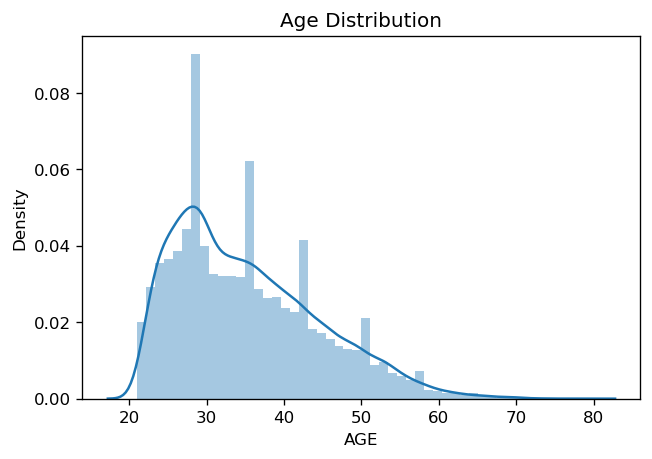

In [19]:
plt.rcParams['figure.dpi'] = 120
sns.distplot(train['AGE'])
plt.title('Age Distribution')

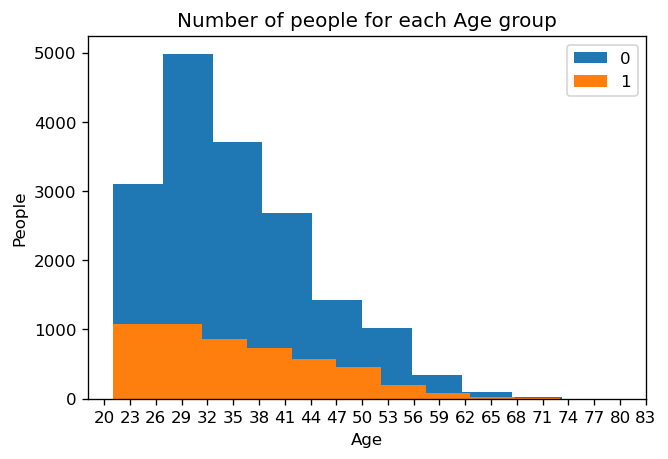

In [20]:
#Here we can see that, between age 20 to 45 most of the people will fall into default payment is 0.
xticks = [i for i in range(20,85,3)]
train.groupby('default.payment.next.month')['AGE'].plot.hist(legend=True, xticks = xticks, 
                                                             title = 'Number of people for each Age group')
plt.xlabel('Age')
plt.ylabel('People')
plt.show()

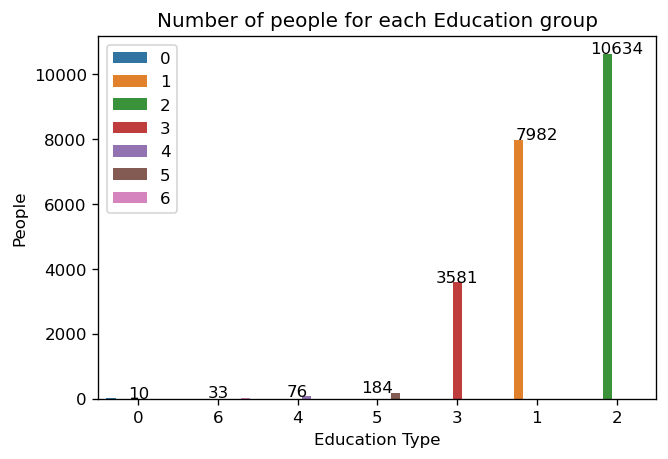

In [21]:
# EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
# Here we can see that in our data set most people are high school degree and above, Most people have university degree.
ax = sns.countplot(x='EDUCATION', data = train, order = train['EDUCATION'].value_counts(ascending=True).index, hue="EDUCATION")
plt.title ('Number of people for each Education group')
labels = train['EDUCATION'].value_counts(ascending=True)
for index, count in enumerate(labels):
    ax.text(index, count, count, horizontalalignment='center')
plt.xlabel('Education Type')
plt.ylabel('People')
plt.legend(loc=0)
#plt.savefig('EDA_Education.png',dpi=500)
plt.show()

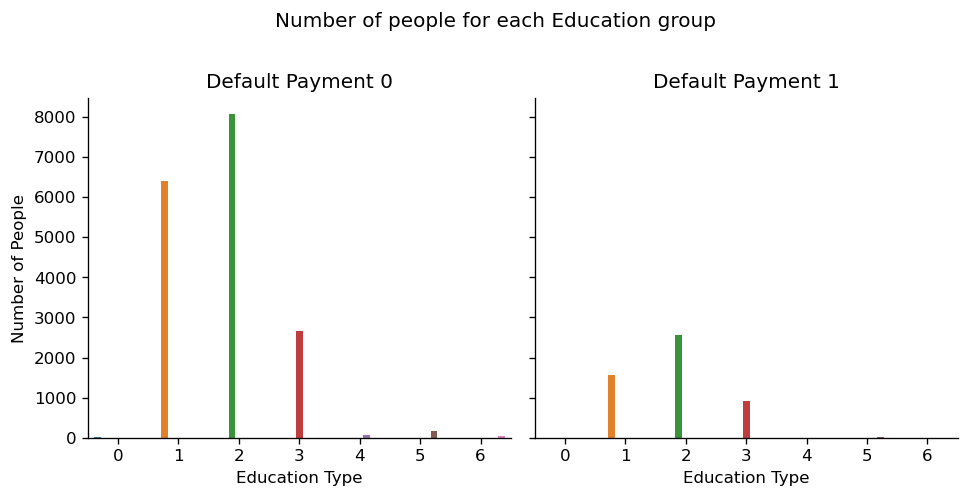

In [22]:
g = sns.catplot(x='EDUCATION', hue='EDUCATION', col='default.payment.next.month',
                data=train, kind="count",
                height=4, aspect=1);
(g.set_axis_labels("Education Type", "Number of People"))
axes = g.axes.flatten()
axes[0].set_title("Default Payment 0")
axes[1].set_title("Default Payment 1")
g.fig.suptitle('Number of people for each Education group')
g.fig.subplots_adjust(top=0.8)
plt.savefig('EDA_Education_2.png',dpi=500)

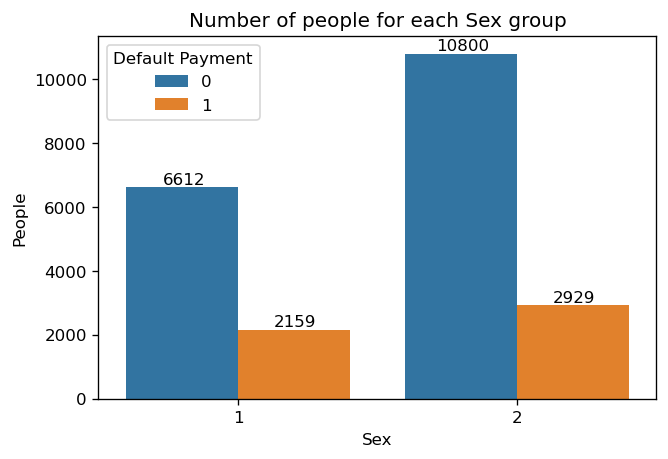

In [23]:
#SEX: Gender (1=male, 2=female)
ax = sns.countplot(x="SEX", hue="default.payment.next.month", data=train)
for rect in ax.patches:
  height = rect.get_height()
  ax.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), xytext=(1, 0),
              textcoords='offset points', ha='center', va='bottom')
plt.title('Number of people for each Sex group')
plt.xlabel('Sex')
plt.ylabel('People')
plt.legend(title='Default Payment')
plt.savefig('EDA_Sex.png',dpi=500)
plt.show()

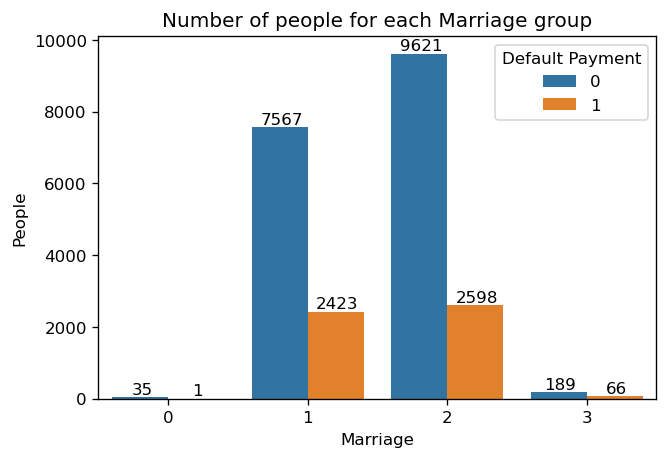

In [24]:
#MARRIAGE: Marital status (1=married, 2=single, 3=others)
ax = sns.countplot(x="MARRIAGE", hue="default.payment.next.month", data=train)
for rect in ax.patches:
  height = rect.get_height()
  ax.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), xytext=(1, 0),
              textcoords='offset points', ha='center', va='bottom')
plt.title('Number of people for each Marriage group')
plt.xlabel('Marriage')
plt.ylabel('People')
plt.legend(title='Default Payment')
plt.savefig('EDA_Marriage.png',dpi=500)
plt.show()

array([[<AxesSubplot:title={'center':'LIMIT_BAL'}>,
        <AxesSubplot:title={'center':'BILL_AMT1'}>,
        <AxesSubplot:title={'center':'BILL_AMT2'}>,
        <AxesSubplot:title={'center':'BILL_AMT3'}>],
       [<AxesSubplot:title={'center':'BILL_AMT4'}>,
        <AxesSubplot:title={'center':'BILL_AMT5'}>,
        <AxesSubplot:title={'center':'BILL_AMT6'}>,
        <AxesSubplot:title={'center':'PAY_AMT1'}>],
       [<AxesSubplot:title={'center':'PAY_AMT2'}>,
        <AxesSubplot:title={'center':'PAY_AMT3'}>,
        <AxesSubplot:title={'center':'PAY_AMT4'}>,
        <AxesSubplot:title={'center':'PAY_AMT5'}>],
       [<AxesSubplot:title={'center':'PAY_AMT6'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

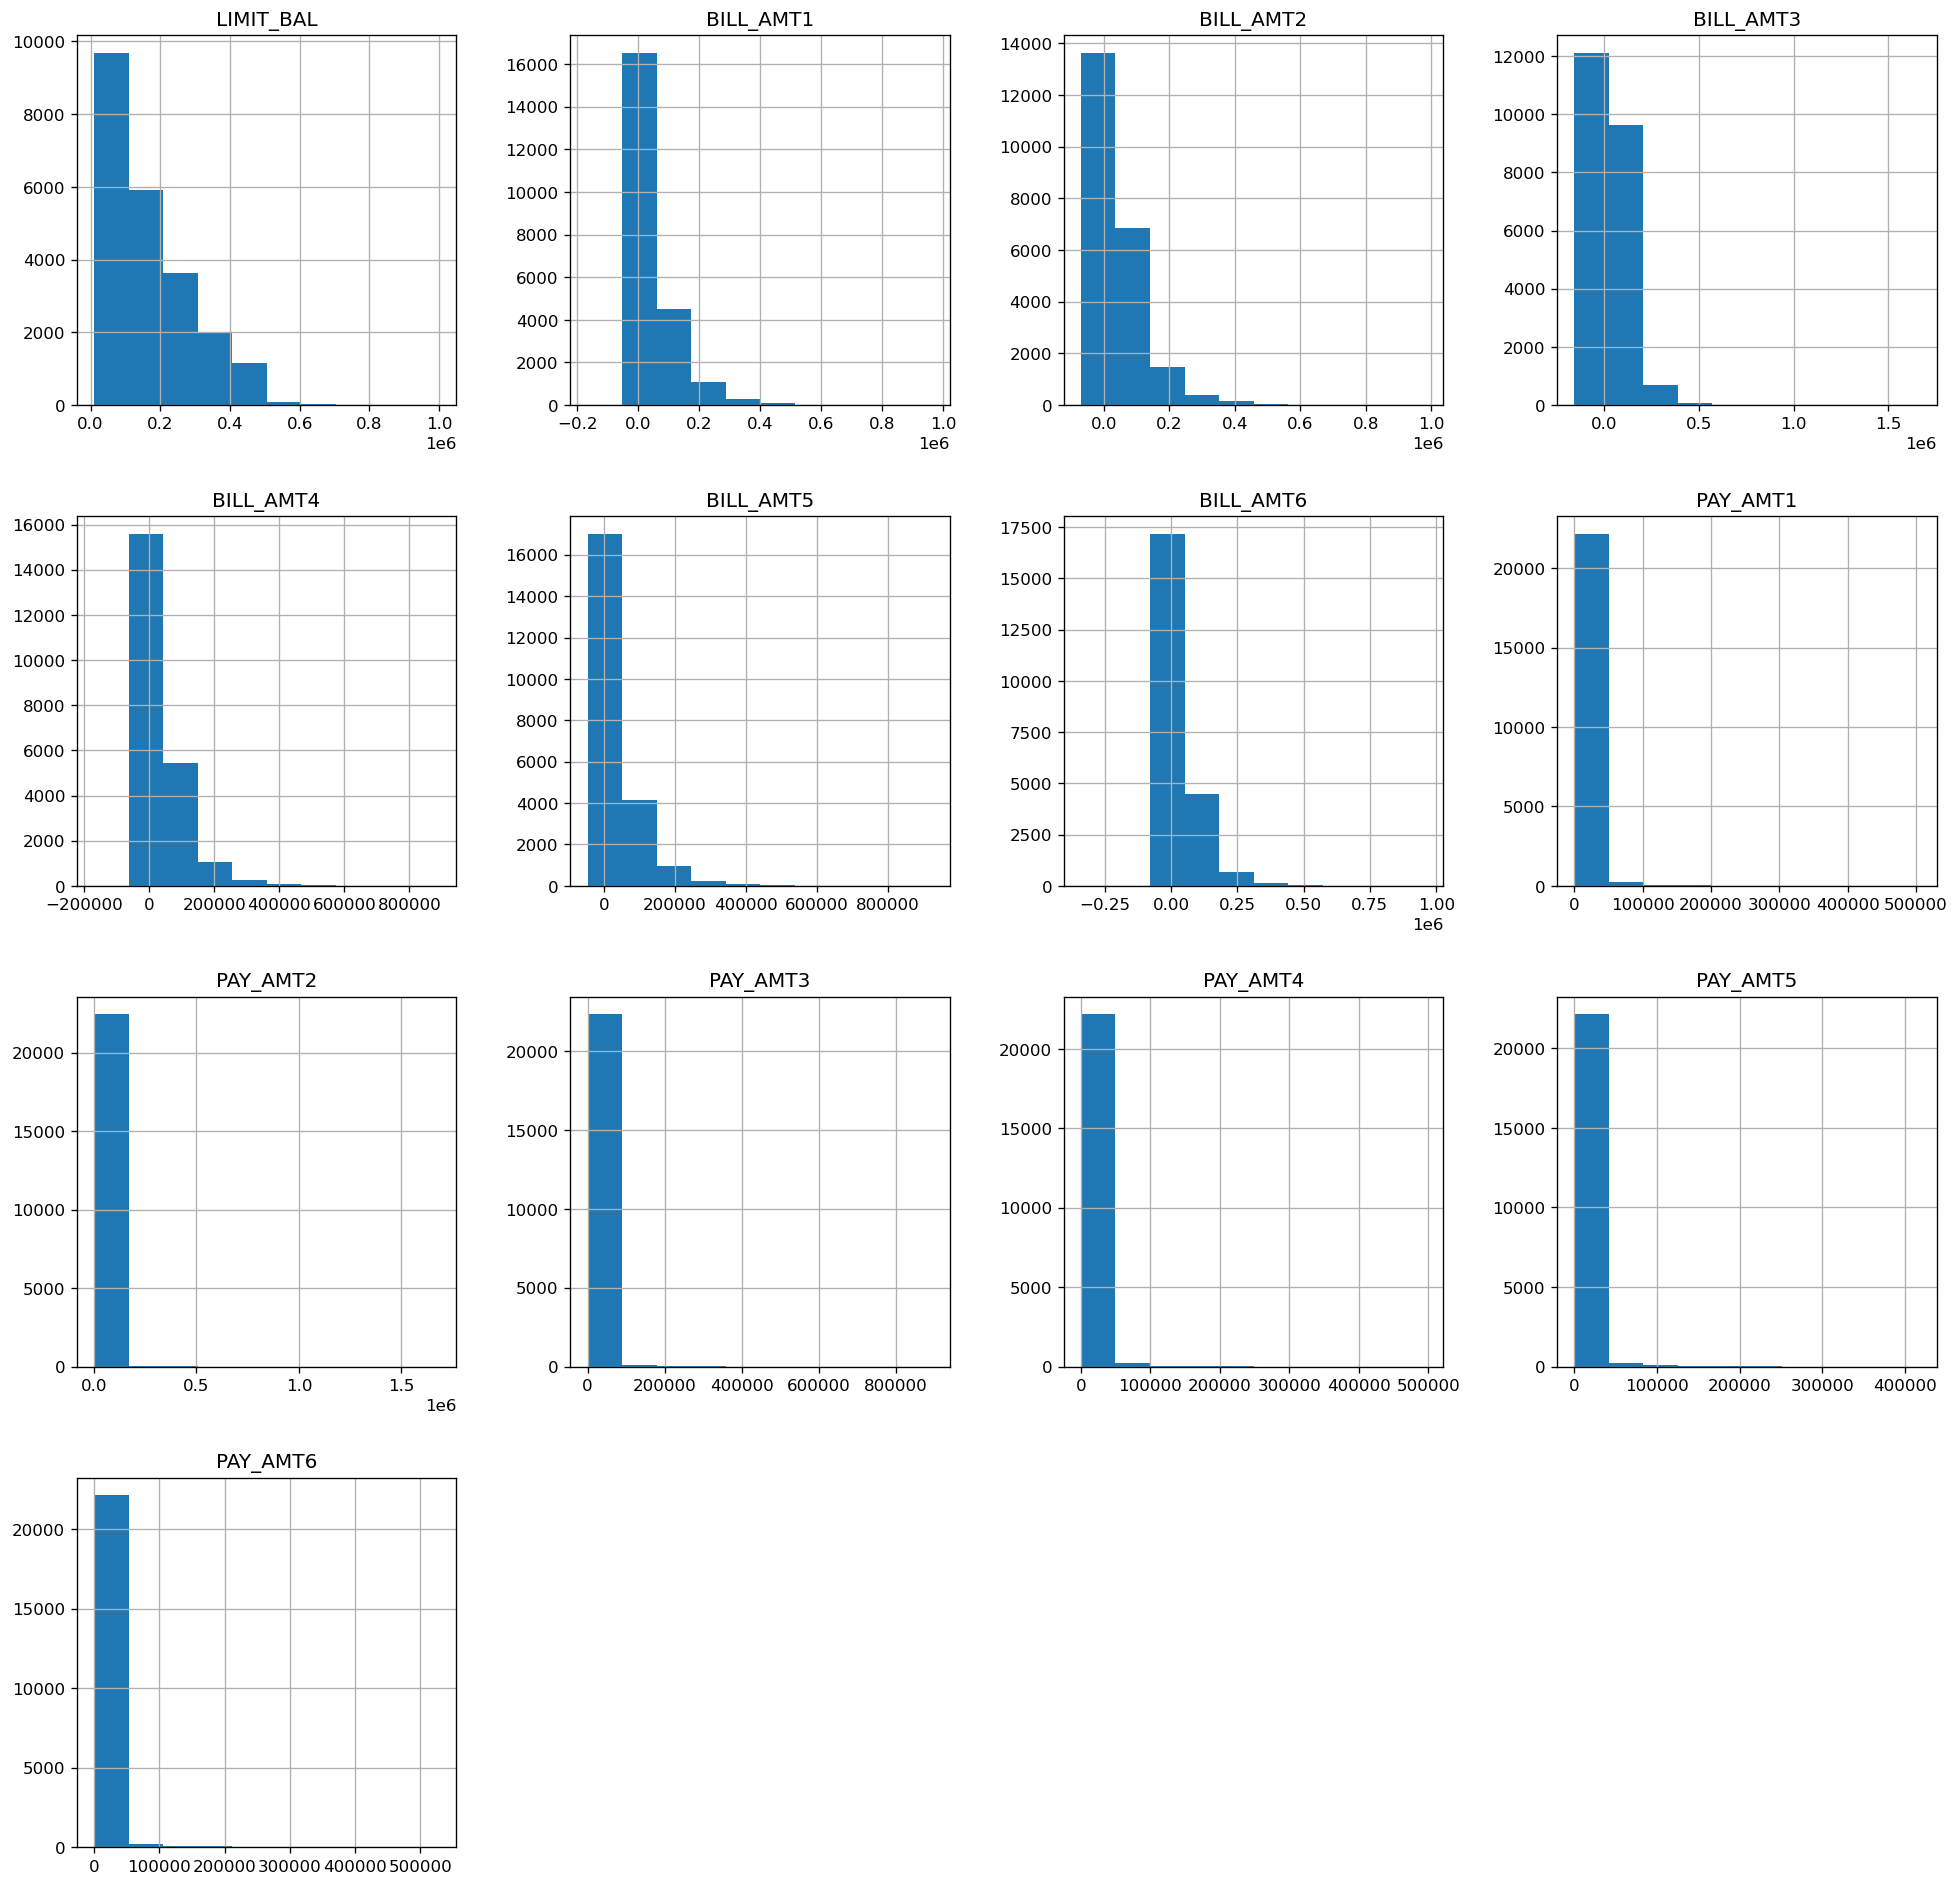

In [25]:
numerical_columns = ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2','BILL_AMT3',
                'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
                'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
#Plots exploring numerical features
df_num = train[numerical_columns]
df_num.hist(figsize=(20, 20))

## Function for CrossValidation

In [5]:
def crossValidation(X_train, y_train, model, cv=5, scoring='roc_auc'):
    skf = StratifiedKFold(n_splits=cv, shuffle=True)
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring=scoring)
    print(f'scores: {scores}')
    print(f'cv_score: {round(scores.mean(), 5)}')

## Function for model scoring

In [6]:
y_test = pd.read_csv("data/test_labels.csv")

def model_score(X_test, model):
    y_pred = model.predict_proba(X_test)
    auc = roc_auc_score(y_test['default.payment.next.month'], y_pred[:,1])
    print(f'auc_score: {auc}')
    fpr, tpr, _ = roc_curve(y_test['default.payment.next.month'],  y_pred[:,1])
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()
    
    pred_cat = model.predict(X_test)
        # confusion matrix
    cat_confusion_matrix = metrics.confusion_matrix(y_test['default.payment.next.month'],pred_cat)
    sns.heatmap(cat_confusion_matrix, annot=True, fmt="d")
    plt.xlabel("Predicted Label", fontsize= 12)
    plt.ylabel("True Label", fontsize= 12)
    plt.show()

## Custom Transformers

### TargetCounter

In [7]:
# Takes feature, label column input
# Count how many times the label was 0/1 for that feature value and add new column

from sklearn.base import BaseEstimator,TransformerMixin

class TargetCounter(BaseEstimator,TransformerMixin):
    def __init__(self, cols=None, target=0):
        self.target = target
        if isinstance(cols, str):
            self.cols = [cols]
        else:
            self.cols = cols

    def fit(self,X,y=None):
        # Encode each element of each column
        self.maps = dict() #dict to store map for each column
        for col in self.cols:
            tmap = dict()
            uniques = X[col].unique()
            for unique in uniques:
                tmap[unique] = y[(X[col]==unique) & (y==self.target)].count()
            self.maps[col] = tmap
        return self
    
    def transform(self,X,y=None):
        Xo = X.copy()
        for col, tmap in self.maps.items():
            vals = np.full(X.shape[0], 0)
            for val, zc in tmap.items():
                vals[X[col]==val] = zc
            Xo[col] = vals
        return Xo
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X, y)

### Thread from kaggle discussion
PAY_0 and PAY_2–PAY_6: These columns show the status of repayments made by each credit-card customer whose details are listed in the dataset. The six columns cover repayments made from April 2005 through September 2005, in reverse order. For example, PAY_0 indicates a customer's repayment status in September 2005 and PAY_6 indicates the customer's repayment status in April 2005.

In each of the six PAY_X columns, the status code -1 means that payment was made on time and the
code 1 means that payment was delayed by one month. The codes 2 through 8 represent delays in
payment by two through eight months, respectively. And 9 means that payment was delayed by nine
or more months.

PAY_0 should ideally be renamed to PAY_1. This will ensure that the PAY_X names conform to
the naming convention used for the BILL_AMTX and PAY_AMTX columns. It will also preclude any
questions about why PAY_0 is followed immediately by PAY_2.


BILL_AMT1–BILL_AMT6: These columns list the amount billed to each customer from April 2005 through September 2005, in reverse order. The amounts are in New Taiwan (NT) dollars.


PAY_AMT1–PAY_AMT6: These columns list, in reverse order, the amount that each customer paid back to the credit-card company from April 2005 through September 2005. Each of these amounts was paid to settle the preceding month's bill, either in full or partially. For example, each September 2005 amount was paid to settle the corresponding customer's August 2005 bill. The amounts are in NT dollars.

## Feature processing pipeline

In [8]:
categorical_columns = ['SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
            'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    # replace missing value with most frequent value in the column
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # onehotencode: converts category to numeric as we were doing with getdummies
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

In [9]:
numerical_columns = ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2','BILL_AMT3',
                'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
                'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')), # replace nan by mean
])

In [10]:
# Combine multiple transformer using ColumnTransformer
fetaure_preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numerical_transformer, numerical_columns ),
        ('categorical', categorical_transformer, categorical_columns),
        ('onecounter', TargetCounter(cols=categorical_columns, target=1), categorical_columns),
])

### Processed train data

In [11]:
# Grab target as y, remove target from X
train_copy = train.copy()
y_train = train_copy['default.payment.next.month']
X_train = train_copy.drop(columns=['default.payment.next.month'])

# Fit the preprocessor using the training data
X_train_p = fetaure_preprocessor.fit_transform(X_train, y_train)
X_train_p.shape

(22500, 155)

### Processed test data

In [12]:
# transform test data
X_test = test.copy()
X_test_p = fetaure_preprocessor.transform(X_test)
X_test_p.shape

(7500, 155)

## Model Training

### Logistic Regression

In [120]:
grid = {
        "C":[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000], 
        "penalty":["l2"]
       }

logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg,grid)
logreg_cv.fit(X_train_p,y_train)

print("tuned hyperparameters :(best parameters)", logreg_cv.best_params_)

tuned hyperparameters :(best parameters) {'C': 5, 'penalty': 'l2'}


#### Retrain Model with whole train data

In [446]:
lr_model = LogisticRegression(C=5, penalty='l2')
lr_model.fit(X_train_p, y_train)

LogisticRegression(C=5)

#### Test Model

auc_score: 0.7621274350705731


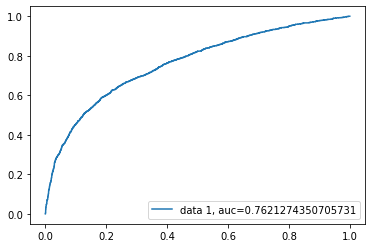

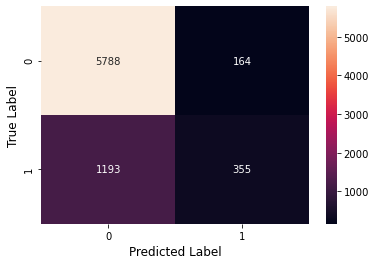

In [447]:
model_score(X_test=X_test_p,model=lr_model)

### RandomForest Classifier

#### Test performance before tuning parameter

auc_score: 0.7696806471583175


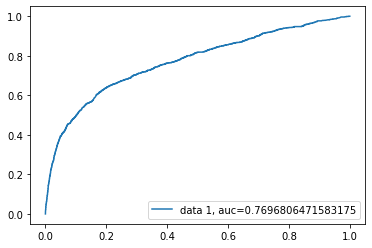

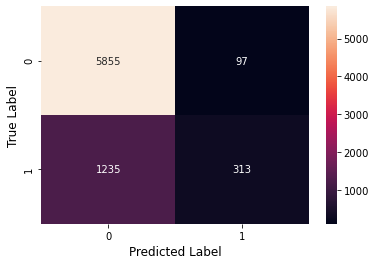

In [16]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=5)
rfc.fit(X_train_p,y_train)
model_score(X_test_p,rfc)

#### Hyperparameter tuning (n_estimators)

In [13]:
for n_estimators in [400, 500, 600, 700]:
    for max_depth in [4]:
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1)
        print(f'\nn_esitmators: {n_estimators}, max_depth: {max_depth}')
        crossValidation(X_train_p, y_train, model)


n_esitmators: 400, max_depth: 4
scores: [0.7694297  0.76138651 0.75586133 0.76909365 0.76317969]
cv_score: 0.76379

n_esitmators: 500, max_depth: 4
scores: [0.76218659 0.7508603  0.763184   0.77378056 0.76719696]
cv_score: 0.76344

n_esitmators: 600, max_depth: 4
scores: [0.75457475 0.75982008 0.76250791 0.76275298 0.77938525]
cv_score: 0.76381

n_esitmators: 700, max_depth: 4
scores: [0.75954093 0.7641185  0.76253866 0.77842638 0.75361321]
cv_score: 0.76365


In [284]:
for n_estimators in [600, 700]:
    for max_depth in [4]:
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1)
        print(f'\nn_esitmators: {n_estimators}, max_depth: {max_depth}')
        crossValidation(X_train_p, y_train, model)


n_esitmators: 600, max_depth: 4
scores: [0.76524907 0.75449167 0.75134328 0.77160451 0.77690403]
cv_score: 0.76392

n_esitmators: 700, max_depth: 4
scores: [0.75766276 0.76053086 0.76055781 0.76808426 0.77062857]
cv_score: 0.76349


#### Hyperparameter tuning (max_depth)

In [285]:
for n_estimators in [600]:
    for max_depth in [4, 5, 6, 7]:
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1)
        print(f'\nn_esitmators: {n_estimators}, max_depth: {max_depth}')
        crossValidation(X_train_p, y_train, model)


n_esitmators: 600, max_depth: 4
scores: [0.75530048 0.76001784 0.76727972 0.76879666 0.76848852]
cv_score: 0.76398

n_esitmators: 600, max_depth: 5
scores: [0.76199151 0.7652904  0.76972649 0.76324646 0.77494522]
cv_score: 0.76704

n_esitmators: 600, max_depth: 6
scores: [0.7762598  0.77249909 0.77822896 0.75492722 0.76794748]
cv_score: 0.76997

n_esitmators: 600, max_depth: 7
scores: [0.7640364  0.77511118 0.76498741 0.77603706 0.77934008]
cv_score: 0.7719


In [14]:
for n_estimators in [600]:
    for max_depth in [5, 8, 11, 13]:
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1)
        print(f'\nn_esitmators: {n_estimators}, max_depth: {max_depth}')
        crossValidation(X_train_p, y_train, model)


n_esitmators: 600, max_depth: 5
scores: [0.7570809  0.75330848 0.76735278 0.78153235 0.77611512]
cv_score: 0.76708

n_esitmators: 600, max_depth: 8
scores: [0.78476905 0.77376889 0.77438982 0.77096071 0.76299012]
cv_score: 0.77338

n_esitmators: 600, max_depth: 11
scores: [0.78511548 0.79414056 0.76478753 0.77232582 0.77098075]
cv_score: 0.77747

n_esitmators: 600, max_depth: 13
scores: [0.78643577 0.76785833 0.78199658 0.77202219 0.77604256]
cv_score: 0.77687


In [288]:
for n_estimators in [600]:
    for max_depth in [12, 13, 14, 15]:
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1)
        print(f'\nn_esitmators: {n_estimators}, max_depth: {max_depth}')
        crossValidation(X_train_p, y_train, model)


n_esitmators: 600, max_depth: 12
scores: [0.75427684 0.77646137 0.78803902 0.78315676 0.78076729]
cv_score: 0.77654

n_esitmators: 600, max_depth: 13
scores: [0.78798923 0.78574755 0.76488712 0.77794603 0.76640621]
cv_score: 0.7766

n_esitmators: 600, max_depth: 14
scores: [0.7812092  0.77423268 0.7817273  0.75673781 0.78634009]
cv_score: 0.77605

n_esitmators: 600, max_depth: 15
scores: [0.77394902 0.76762785 0.76740554 0.78919099 0.77831642]
cv_score: 0.7753


#### Retrain Model with whole train data

In [15]:
n_estimators = 600
max_depth = 11

rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1)
rf_model.fit(X_train_p, y_train)

RandomForestClassifier(max_depth=11, n_estimators=600, n_jobs=-1)

#### Test Model

auc_score: 0.788884883981412


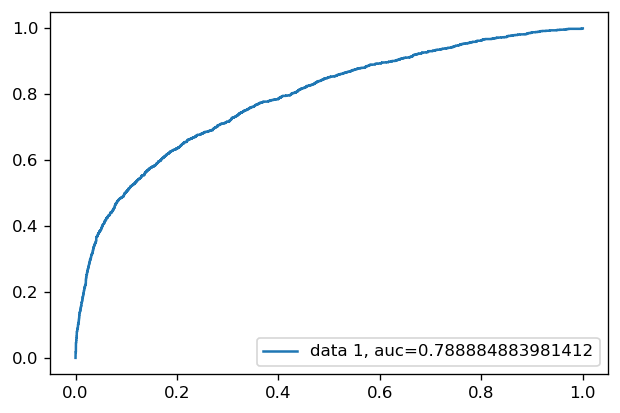

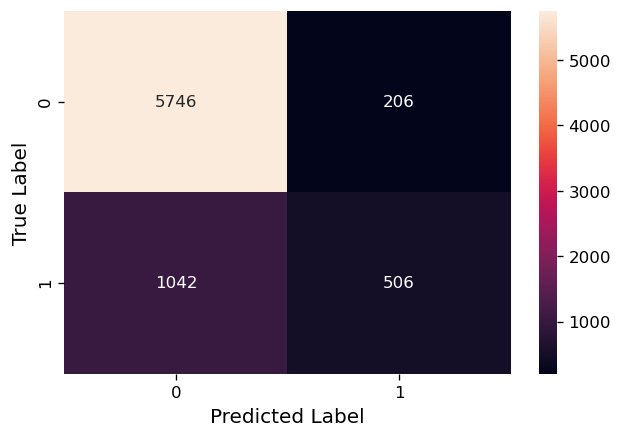

In [26]:
model_score(X_test=X_test_p, model=rf_model)

#### Hyperparameter tuning (grid search)

In [421]:
grid = {
        "n_estimators":[590, 600, 610], 
        "max_depth":[10, 11, 12],
        "n_jobs":[-1]
       }

rfcg = RandomForestClassifier()
rfcg_cv = GridSearchCV(rfcg,grid)
rfcg_cv.fit(X_train_p,y_train)

print("tuned hyperparameters :(best parameters)", rfcg_cv.best_params_)

tuned hyperparameters :(best parameters) {'max_depth': 10, 'n_estimators': 610, 'n_jobs': -1}


#### Retrain model with whole training data

In [448]:
rf_model = RandomForestClassifier(n_estimators=600, max_depth=11, random_state=5, n_jobs=-1)
rf_model.fit(X_train_p, y_train)

RandomForestClassifier(max_depth=11, n_estimators=600, n_jobs=-1,
                       random_state=5)

#### Test model

auc_score: 0.788836369248562


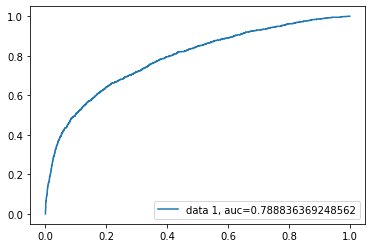

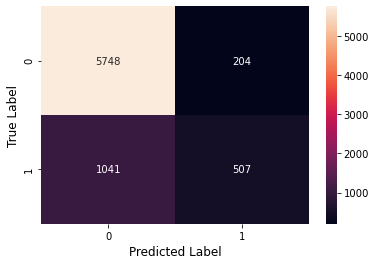

In [449]:
model_score(X_test_p, rf_model)

### XGBClassifier

#### Hyperparameter tuning (n_estimators)

In [51]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

for colsample_bytree in [0.3]:
    for learning_rate in [0.01]:
        for n_estimators in [200, 300, 400, 500, 600, 700]:
                for max_depth in [4]:
                    print(f'\ncolsample_bytree: {colsample_bytree}, learning_rate: {learning_rate}, 
                          n_estimators: {n_estimators}, max_depth: {max_depth}')
                    model = XGBClassifier(colsample_bytree=colsample_bytree,
                                          early_stopping_rounds=5, n_estimators=n_estimators, 
                                          max_depth=max_depth, n_jobs=-1, 
                                          learning_rate=learning_rate, objective='binary:logistic', 
                                          verbosity = 0, silent=True)
                    crossValidation(X_train=X_train_p, y_train=y_train, model=model)


colsample_bytree: 0.3, learning_rate: 0.01, n_estimators: 200, max_depth: 4
scores: [0.77388808 0.75964926 0.76133898 0.77744508 0.7845374 ]
cv_score: 0.77137

colsample_bytree: 0.3, learning_rate: 0.01, n_estimators: 300, max_depth: 4
scores: [0.77617954 0.78575813 0.76519631 0.76825124 0.77367935]
cv_score: 0.77381

colsample_bytree: 0.3, learning_rate: 0.01, n_estimators: 400, max_depth: 4
scores: [0.78656131 0.7794309  0.7546347  0.77644175 0.7850272 ]
cv_score: 0.77642

colsample_bytree: 0.3, learning_rate: 0.01, n_estimators: 500, max_depth: 4
scores: [0.77789098 0.77171919 0.77784302 0.77237296 0.78616195]
cv_score: 0.7772

colsample_bytree: 0.3, learning_rate: 0.01, n_estimators: 600, max_depth: 4
scores: [0.77044249 0.76990746 0.77318519 0.78946299 0.78945481]
cv_score: 0.77849

colsample_bytree: 0.3, learning_rate: 0.01, n_estimators: 700, max_depth: 4
scores: [0.76984328 0.77505419 0.79087778 0.77697616 0.77935335]
cv_score: 0.77842


In [53]:
for colsample_bytree in [0.3]:
    for learning_rate in [0.01]:
        for n_estimators in [800, 900, 1000, 1100, 1200]:
                for max_depth in [4]:
                    print(f'\ncolsample_bytree: {colsample_bytree}, learning_rate: {learning_rate}, n_estimators: {n_estimators}, max_depth: {max_depth}')
                    model = XGBClassifier(colsample_bytree=colsample_bytree, early_stopping_rounds=5, n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, 
                                          learning_rate=learning_rate, objective='binary:logistic', verbosity = 0, silent=True)
                    crossValidation(X_train=X_train_p, y_train=y_train, model=model)


colsample_bytree: 0.3, learning_rate: 0.01, n_estimators: 800, max_depth: 4
scores: [0.76136267 0.76752741 0.7964553  0.78485457 0.78113839]
cv_score: 0.77827

colsample_bytree: 0.3, learning_rate: 0.01, n_estimators: 900, max_depth: 4
scores: [0.76972014 0.77646208 0.78735602 0.7825011  0.78034736]
cv_score: 0.77928

colsample_bytree: 0.3, learning_rate: 0.01, n_estimators: 1000, max_depth: 4
scores: [0.78669334 0.77512007 0.77947561 0.78249277 0.76829175]
cv_score: 0.77841

colsample_bytree: 0.3, learning_rate: 0.01, n_estimators: 1100, max_depth: 4
scores: [0.78172674 0.78099606 0.77020819 0.78491626 0.77328412]
cv_score: 0.77823

colsample_bytree: 0.3, learning_rate: 0.01, n_estimators: 1200, max_depth: 4
scores: [0.78032548 0.78385669 0.76079972 0.78255417 0.7833102 ]
cv_score: 0.77817


#### Hyperparameter tuning (max_depth)

In [54]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

for colsample_bytree in [0.3]:
    for learning_rate in [0.01]:
        for n_estimators in [600]:
                for max_depth in [5,6,7,8]:
                    print(f'\ncolsample_bytree: {colsample_bytree}, learning_rate: {learning_rate},
                          n_estimators: {n_estimators}, max_depth: {max_depth}')
                    model = XGBClassifier(colsample_bytree=colsample_bytree, early_stopping_rounds=5, 
                                          n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, 
                                          learning_rate=learning_rate, objective='binary:logistic',
                                          verbosity = 0, silent=True)
                    crossValidation(X_train=X_train_p, y_train=y_train, model=model)


colsample_bytree: 0.3, learning_rate: 0.01, n_estimators: 600, max_depth: 5
scores: [0.77791919 0.77895074 0.77862927 0.77526    0.78402317]
cv_score: 0.77896

colsample_bytree: 0.3, learning_rate: 0.01, n_estimators: 600, max_depth: 6
scores: [0.77619901 0.77397173 0.77842545 0.78752847 0.79101711]
cv_score: 0.78143

colsample_bytree: 0.3, learning_rate: 0.01, n_estimators: 600, max_depth: 7
scores: [0.78748142 0.7734635  0.78440484 0.76876702 0.78475478]
cv_score: 0.77977

colsample_bytree: 0.3, learning_rate: 0.01, n_estimators: 600, max_depth: 8
scores: [0.784862   0.77382982 0.77971682 0.78178883 0.77492673]
cv_score: 0.77902


In [55]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

for colsample_bytree in [0.3]:
    for learning_rate in [0.01]:
        for n_estimators in [900]:
                for max_depth in [5,6,7,8]:
                    print(f'\ncolsample_bytree: {colsample_bytree}, learning_rate: {learning_rate}, n_estimators: {n_estimators}, max_depth: {max_depth}')
                    model = XGBClassifier(colsample_bytree=colsample_bytree, early_stopping_rounds=5, n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, 
                                          learning_rate=learning_rate, objective='binary:logistic', verbosity = 0, silent=True)
                    crossValidation(X_train=X_train_p, y_train=y_train, model=model)


colsample_bytree: 0.3, learning_rate: 0.01, n_estimators: 900, max_depth: 5
scores: [0.79048198 0.77862462 0.78582316 0.76317165 0.77920401]
cv_score: 0.77946

colsample_bytree: 0.3, learning_rate: 0.01, n_estimators: 900, max_depth: 6
scores: [0.77855705 0.77736766 0.78369814 0.77592456 0.77897844]
cv_score: 0.77891

colsample_bytree: 0.3, learning_rate: 0.01, n_estimators: 900, max_depth: 7
scores: [0.77624387 0.77376508 0.79062177 0.77930211 0.77484571]
cv_score: 0.77896

colsample_bytree: 0.3, learning_rate: 0.01, n_estimators: 900, max_depth: 8
scores: [0.77874254 0.78160091 0.76838476 0.77769605 0.78708948]
cv_score: 0.7787


#### Hyperparameter tuning (colsample_bytree)

In [416]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

for colsample_bytree in [0.25, 0.3, 0.35]:
    for learning_rate in [0.01]:
        for n_estimators in [600]:
                for max_depth in [7]:
                    print(f'\ncolsample_bytree: {colsample_bytree}, learning_rate: {learning_rate}, 
                          n_estimators: {n_estimators}, max_depth: {max_depth}')
                    model = XGBClassifier(colsample_bytree=colsample_bytree, early_stopping_rounds=5, 
                                          n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, 
                                          learning_rate=learning_rate, objective='binary:logistic',
                                          verbosity = 0, silent=True)
                    crossValidation(X_train=X_train_p, y_train=y_train, model=model)


colsample_bytree: 0.25, learning_rate: 0.01, n_estimators: 600, max_depth: 7
scores: [0.77230994 0.782031   0.78358629 0.77537476 0.78785708]
cv_score: 0.78023

colsample_bytree: 0.3, learning_rate: 0.01, n_estimators: 600, max_depth: 7
scores: [0.77987692 0.78449638 0.78065739 0.76992491 0.78466754]
cv_score: 0.77992

colsample_bytree: 0.35, learning_rate: 0.01, n_estimators: 600, max_depth: 7
scores: [0.78177187 0.77303102 0.75896612 0.78656438 0.79392857]
cv_score: 0.77885


#### Retrain Model with whole train data

In [ ]:
colsample_bytree = 0.25
n_estimators = 600
max_depth = 7
learning_rate = 0.01

xgb_model = XGBClassifier(colsample_bytree=colsample_bytree, early_stopping_rounds=5,
                          n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, 
                          learning_rate=learning_rate, objective='binary:logistic')
xgb_model.fit(X_train_p, y_train)

#### Test Model

auc_score: 0.796799948685088


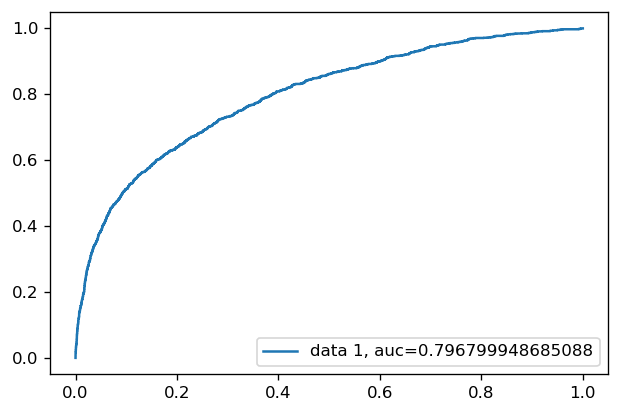

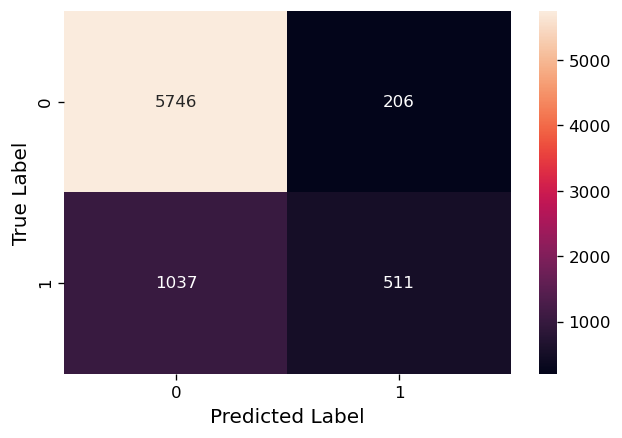

In [28]:
model_score(X_test=X_test_p, model=xgb_model)

#### Hyperparameter tuning (grid search)

In [ ]:
grid = {
        "n_estimators":[590, 600, 610], 
        "max_depth":[6, 7, 8],
        "colsample_bytree" : [0.25],
        "learning_rate" : [0.01],
        "n_jobs":[-1]
       }

xgb = XGBClassifier()
xgb_cv = GridSearchCV(xgb,grid)
xgb_cv.fit(X_train_p,y_train)

print("tuned hyperparameters :(best parameters)", xgb_cv.best_params_)

#### Retrain Model with whole train data

In [451]:
colsample_bytree = 0.25
n_estimators = 600
max_depth = 6
learning_rate = 0.01

xgb_model = XGBClassifier(colsample_bytree=colsample_bytree, early_stopping_rounds=5, 
                          n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, 
                          learning_rate=learning_rate, objective='binary:logistic')
xgb_model.fit(X_train_p, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.25,
              early_stopping_rounds=5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=600, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

#### Test model

auc_score: 0.7964926887103719


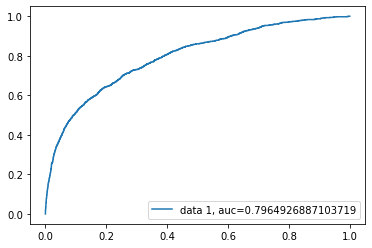

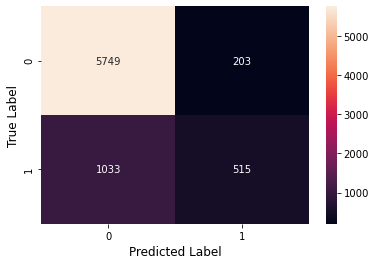

In [452]:
model_score(X_test=X_test_p, model=xgb_model)

### CatBoost Classifier

In [44]:
catb = CatBoostClassifier(
    custom_loss='AUC',
    random_seed=1,
    logging_level='Silent',
    loss_function='MultiClass'
)

In [45]:
catb.fit(
    X_train, y_train
)

In [46]:
model_score(X_test=X_test, model=catb)

auc_score: 0.7836978233273596


#### 2nd Cat Model - parameter adjustments

In [47]:
catb2 = CatBoostClassifier(custom_loss=[catmets.Accuracy()],
                          learning_rate=0.055, 
                          n_estimators=1000, 
                          subsample=0.075, 
                          max_depth=3, 
                          verbose=100,
                          l2_leaf_reg = 7,
                          bootstrap_type="Bernoulli",
                          class_weights=[1, 1],
                          loss_function='MultiClass')

In [48]:
categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
catb2.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    )

0:	learn: 0.6703845	total: 4.45ms	remaining: 4.44s
100:	learn: 0.4422624	total: 358ms	remaining: 3.19s
200:	learn: 0.4377894	total: 721ms	remaining: 2.87s
300:	learn: 0.4350197	total: 1.32s	remaining: 3.06s
400:	learn: 0.4331426	total: 1.76s	remaining: 2.64s
500:	learn: 0.4314011	total: 2.16s	remaining: 2.15s
600:	learn: 0.4301015	total: 2.57s	remaining: 1.71s
700:	learn: 0.4288939	total: 2.99s	remaining: 1.27s
800:	learn: 0.4277478	total: 3.52s	remaining: 874ms
900:	learn: 0.4267326	total: 3.96s	remaining: 435ms
999:	learn: 0.4257813	total: 4.41s	remaining: 0us


In [49]:
cv_params = catb2.get_params()

cv_data = catcross(
    Pool(X_train, y_train, cat_features=categorical_features_indices),
    cv_params
    )

Training on fold [0/3]
0:	learn: 0.6708201	test: 0.6707703	best: 0.6707703 (0)	total: 6.96ms	remaining: 6.95s
100:	learn: 0.4430222	test: 0.4419381	best: 0.4419381 (100)	total: 352ms	remaining: 3.13s
200:	learn: 0.4383795	test: 0.4380910	best: 0.4380910 (200)	total: 698ms	remaining: 2.77s
300:	learn: 0.4352206	test: 0.4361840	best: 0.4361840 (300)	total: 1.07s	remaining: 2.49s
400:	learn: 0.4328231	test: 0.4350958	best: 0.4350958 (400)	total: 1.65s	remaining: 2.46s
500:	learn: 0.4308539	test: 0.4340142	best: 0.4340142 (500)	total: 2.13s	remaining: 2.12s
600:	learn: 0.4291801	test: 0.4335819	best: 0.4335700 (594)	total: 2.51s	remaining: 1.67s
700:	learn: 0.4275809	test: 0.4333903	best: 0.4333834 (687)	total: 2.98s	remaining: 1.27s
800:	learn: 0.4261340	test: 0.4330736	best: 0.4330736 (800)	total: 3.46s	remaining: 860ms
900:	learn: 0.4248191	test: 0.4327099	best: 0.4326990 (889)	total: 3.82s	remaining: 420ms
999:	learn: 0.4235472	test: 0.4327186	best: 0.4326693 (976)	total: 4.18s	remaini

In [50]:
print('Best validation accuracy score: {:.2f}±{:.2f} on step {}'.format(
    np.max(cv_data['test-MultiClass-mean']),
    cv_data['test-MultiClass-std'][np.argmax(cv_data['test-MultiClass-mean'])],
    np.argmax(cv_data['test-MultiClass-mean'])
))
print('Precise validation accuracy score: {}'.format(np.max(cv_data['test-MultiClass-mean'])))

Best validation accuracy score: 0.67±0.00 on step 0
Precise validation accuracy score: 0.6710285298580695


In [51]:
params = {
    'iterations': 500,
    'learning_rate': 0.1,
    'eval_metric': 'AUC',
    'random_seed': 1,
    'logging_level': 'Silent',
    'use_best_model': False
}
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(X_test, y_test.drop('ID', axis=1), cat_features=categorical_features_indices)

In [52]:
catb22 = CatBoostClassifier(**params)
catb22.fit(train_pool, eval_set=validate_pool)

best_model_params = params.copy()
best_model_params.update({
    'use_best_model': True
})
best_model = CatBoostClassifier(**best_model_params)
best_model.fit(train_pool, eval_set=validate_pool)

In [58]:
print('Simple model validation accuracy: {:.4}'.format(
    accuracy_score(y_test.drop('ID', axis=1), catb22.predict(X_test))
))
print('')

print('Best model validation accuracy: {:.4}'.format(
    accuracy_score(y_test.drop('ID', axis=1), best_model.predict(X_test))
))

Simple model validation accuracy: 0.8319

Best model validation accuracy: 0.8355


In [59]:
model_score(X_test, catb22)

auc_score: 0.792514480616682


#### 3rd Cat Model - more parameter adjustments

In [60]:
cat_model = CatBoostClassifier(
    iterations = 1000, # 1000 are ideal
    loss_function='MultiClass',
    bootstrap_type = "Bayesian",
    eval_metric = 'AUC',
    leaf_estimation_iterations = 100,
    random_strength = 0.5,
    depth = 7,
    l2_leaf_reg = 5,
    learning_rate=0.1,
    bagging_temperature = 0.5,
)

# training the model
cat_model.fit(X_train,y_train)

# predicting the model output
y_pred_cat = cat_model.predict(X_test)

0:	total: 63.2ms	remaining: 1m 3s
1:	total: 122ms	remaining: 1m
2:	total: 173ms	remaining: 57.7s
3:	total: 224ms	remaining: 55.9s
4:	total: 280ms	remaining: 55.7s
5:	total: 321ms	remaining: 53.1s
6:	total: 375ms	remaining: 53.2s
7:	total: 429ms	remaining: 53.2s
8:	total: 489ms	remaining: 53.9s
9:	total: 551ms	remaining: 54.6s
10:	total: 605ms	remaining: 54.4s
11:	total: 673ms	remaining: 55.4s
12:	total: 763ms	remaining: 57.9s
13:	total: 858ms	remaining: 1m
14:	total: 923ms	remaining: 1m
15:	total: 983ms	remaining: 1m
16:	total: 1.04s	remaining: 1m
17:	total: 1.1s	remaining: 1m
18:	total: 1.16s	remaining: 59.7s
19:	total: 1.22s	remaining: 59.7s
20:	total: 1.27s	remaining: 59.5s
21:	total: 1.33s	remaining: 59.2s
22:	total: 1.39s	remaining: 58.9s
23:	total: 1.45s	remaining: 58.9s
24:	total: 1.5s	remaining: 58.7s
25:	total: 1.56s	remaining: 58.5s
26:	total: 1.61s	remaining: 58.2s
27:	total: 1.68s	remaining: 58.3s
28:	total: 1.75s	remaining: 58.4s
29:	total: 1.83s	remaining: 59.1s
30:	total

241:	total: 15.6s	remaining: 48.9s
242:	total: 15.7s	remaining: 48.8s
243:	total: 15.7s	remaining: 48.8s
244:	total: 15.8s	remaining: 48.7s
245:	total: 15.9s	remaining: 48.7s
246:	total: 16s	remaining: 48.6s
247:	total: 16s	remaining: 48.6s
248:	total: 16.1s	remaining: 48.6s
249:	total: 16.2s	remaining: 48.5s
250:	total: 16.2s	remaining: 48.4s
251:	total: 16.3s	remaining: 48.4s
252:	total: 16.4s	remaining: 48.4s
253:	total: 16.5s	remaining: 48.3s
254:	total: 16.5s	remaining: 48.3s
255:	total: 16.6s	remaining: 48.2s
256:	total: 16.7s	remaining: 48.2s
257:	total: 16.7s	remaining: 48.1s
258:	total: 16.8s	remaining: 48.1s
259:	total: 16.9s	remaining: 48s
260:	total: 16.9s	remaining: 47.9s
261:	total: 17s	remaining: 47.9s
262:	total: 17.1s	remaining: 47.9s
263:	total: 17.2s	remaining: 47.9s
264:	total: 17.3s	remaining: 47.9s
265:	total: 17.4s	remaining: 48s
266:	total: 17.5s	remaining: 48s
267:	total: 17.6s	remaining: 47.9s
268:	total: 17.6s	remaining: 47.9s
269:	total: 17.7s	remaining: 47.

479:	total: 54.6s	remaining: 59.1s
480:	total: 54.8s	remaining: 59.1s
481:	total: 55s	remaining: 59.1s
482:	total: 55.2s	remaining: 59.1s
483:	total: 55.4s	remaining: 59s
484:	total: 55.6s	remaining: 59s
485:	total: 55.8s	remaining: 59s
486:	total: 56s	remaining: 59s
487:	total: 56.2s	remaining: 58.9s
488:	total: 56.3s	remaining: 58.9s
489:	total: 56.5s	remaining: 58.8s
490:	total: 56.7s	remaining: 58.8s
491:	total: 56.9s	remaining: 58.7s
492:	total: 57s	remaining: 58.7s
493:	total: 57.2s	remaining: 58.6s
494:	total: 57.4s	remaining: 58.5s
495:	total: 57.5s	remaining: 58.5s
496:	total: 57.7s	remaining: 58.4s
497:	total: 57.9s	remaining: 58.4s
498:	total: 58.1s	remaining: 58.3s
499:	total: 58.3s	remaining: 58.3s
500:	total: 58.5s	remaining: 58.2s
501:	total: 58.7s	remaining: 58.2s
502:	total: 58.9s	remaining: 58.2s
503:	total: 59.1s	remaining: 58.1s
504:	total: 59.3s	remaining: 58.1s
505:	total: 59.4s	remaining: 58s
506:	total: 59.6s	remaining: 58s
507:	total: 59.8s	remaining: 57.9s
508

713:	total: 1m 35s	remaining: 38.2s
714:	total: 1m 35s	remaining: 38s
715:	total: 1m 35s	remaining: 37.9s
716:	total: 1m 35s	remaining: 37.8s
717:	total: 1m 35s	remaining: 37.7s
718:	total: 1m 36s	remaining: 37.6s
719:	total: 1m 36s	remaining: 37.5s
720:	total: 1m 36s	remaining: 37.3s
721:	total: 1m 36s	remaining: 37.2s
722:	total: 1m 36s	remaining: 37.1s
723:	total: 1m 37s	remaining: 37s
724:	total: 1m 37s	remaining: 36.9s
725:	total: 1m 37s	remaining: 36.8s
726:	total: 1m 37s	remaining: 36.7s
727:	total: 1m 37s	remaining: 36.6s
728:	total: 1m 38s	remaining: 36.4s
729:	total: 1m 38s	remaining: 36.3s
730:	total: 1m 38s	remaining: 36.2s
731:	total: 1m 38s	remaining: 36.1s
732:	total: 1m 38s	remaining: 36s
733:	total: 1m 39s	remaining: 35.9s
734:	total: 1m 39s	remaining: 35.8s
735:	total: 1m 39s	remaining: 35.7s
736:	total: 1m 39s	remaining: 35.5s
737:	total: 1m 39s	remaining: 35.4s
738:	total: 1m 39s	remaining: 35.3s
739:	total: 1m 40s	remaining: 35.2s
740:	total: 1m 40s	remaining: 35.1

945:	total: 2m 17s	remaining: 7.84s
946:	total: 2m 17s	remaining: 7.7s
947:	total: 2m 17s	remaining: 7.56s
948:	total: 2m 17s	remaining: 7.41s
949:	total: 2m 18s	remaining: 7.27s
950:	total: 2m 18s	remaining: 7.13s
951:	total: 2m 18s	remaining: 6.99s
952:	total: 2m 18s	remaining: 6.85s
953:	total: 2m 19s	remaining: 6.71s
954:	total: 2m 19s	remaining: 6.58s
955:	total: 2m 19s	remaining: 6.43s
956:	total: 2m 19s	remaining: 6.29s
957:	total: 2m 20s	remaining: 6.14s
958:	total: 2m 20s	remaining: 6s
959:	total: 2m 20s	remaining: 5.85s
960:	total: 2m 20s	remaining: 5.71s
961:	total: 2m 20s	remaining: 5.57s
962:	total: 2m 21s	remaining: 5.42s
963:	total: 2m 21s	remaining: 5.28s
964:	total: 2m 21s	remaining: 5.13s
965:	total: 2m 21s	remaining: 4.99s
966:	total: 2m 22s	remaining: 4.84s
967:	total: 2m 22s	remaining: 4.7s
968:	total: 2m 22s	remaining: 4.55s
969:	total: 2m 22s	remaining: 4.41s
970:	total: 2m 22s	remaining: 4.26s
971:	total: 2m 23s	remaining: 4.12s
972:	total: 2m 23s	remaining: 3.9

accuracy of the catboost:  0.8269333333333333


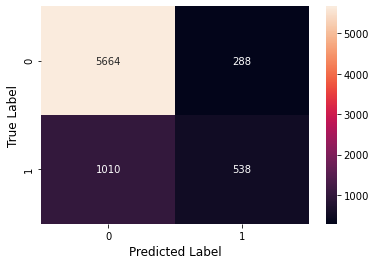

In [65]:
# printing the accuracy of the tuned model
print("accuracy of the catboost: ", accuracy_score(y_test.drop('ID', axis=1),y_pred_cat))

# confusion matrix
cat_confusion_matrix = metrics.confusion_matrix(y_test.drop('ID', axis=1),y_pred_cat)
sns.heatmap(cat_confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [66]:
model_score(X_test, cat_model)

auc_score: 0.7570967720228667


#### 4th Cat Model - with categorical features

In [15]:
categorical_ft_base = ['SEX', 'EDUCATION', 'MARRIAGE']
cat_model_base = CatBoostClassifier (random_state = 42, eval_metric = 'AUC')
cat_model_base.fit(X_train, y_train, early_stopping_rounds = 100, cat_features = categorical_ft_base)
pred_cat = cat_model_base.predict(X_test)

Learning rate set to 0.038933
0:	total: 66.3ms	remaining: 1m 6s
1:	total: 72.9ms	remaining: 36.4s
2:	total: 78.9ms	remaining: 26.2s
3:	total: 85.4ms	remaining: 21.3s
4:	total: 91.5ms	remaining: 18.2s
5:	total: 97.2ms	remaining: 16.1s
6:	total: 104ms	remaining: 14.7s
7:	total: 110ms	remaining: 13.6s
8:	total: 115ms	remaining: 12.6s
9:	total: 121ms	remaining: 12s
10:	total: 127ms	remaining: 11.4s
11:	total: 133ms	remaining: 10.9s
12:	total: 138ms	remaining: 10.5s
13:	total: 144ms	remaining: 10.1s
14:	total: 151ms	remaining: 9.88s
15:	total: 157ms	remaining: 9.64s
16:	total: 163ms	remaining: 9.42s
17:	total: 167ms	remaining: 9.09s
18:	total: 172ms	remaining: 8.9s
19:	total: 179ms	remaining: 8.75s
20:	total: 185ms	remaining: 8.63s
21:	total: 191ms	remaining: 8.49s
22:	total: 197ms	remaining: 8.37s
23:	total: 209ms	remaining: 8.48s
24:	total: 215ms	remaining: 8.4s
25:	total: 221ms	remaining: 8.3s
26:	total: 229ms	remaining: 8.26s
27:	total: 236ms	remaining: 8.18s
28:	total: 242ms	remaining:

258:	total: 1.8s	remaining: 5.15s
259:	total: 1.81s	remaining: 5.15s
260:	total: 1.82s	remaining: 5.14s
261:	total: 1.82s	remaining: 5.14s
262:	total: 1.83s	remaining: 5.13s
263:	total: 1.84s	remaining: 5.13s
264:	total: 1.85s	remaining: 5.12s
265:	total: 1.85s	remaining: 5.11s
266:	total: 1.86s	remaining: 5.1s
267:	total: 1.86s	remaining: 5.09s
268:	total: 1.87s	remaining: 5.08s
269:	total: 1.88s	remaining: 5.07s
270:	total: 1.88s	remaining: 5.07s
271:	total: 1.89s	remaining: 5.06s
272:	total: 1.9s	remaining: 5.05s
273:	total: 1.9s	remaining: 5.04s
274:	total: 1.91s	remaining: 5.03s
275:	total: 1.91s	remaining: 5.02s
276:	total: 1.92s	remaining: 5.01s
277:	total: 1.93s	remaining: 5s
278:	total: 1.93s	remaining: 4.99s
279:	total: 1.94s	remaining: 4.98s
280:	total: 1.94s	remaining: 4.97s
281:	total: 1.95s	remaining: 4.97s
282:	total: 1.96s	remaining: 4.96s
283:	total: 1.96s	remaining: 4.95s
284:	total: 1.97s	remaining: 4.94s
285:	total: 1.98s	remaining: 4.93s
286:	total: 1.98s	remaining

501:	total: 3.41s	remaining: 3.38s
502:	total: 3.42s	remaining: 3.38s
503:	total: 3.42s	remaining: 3.37s
504:	total: 3.43s	remaining: 3.36s
505:	total: 3.44s	remaining: 3.35s
506:	total: 3.44s	remaining: 3.35s
507:	total: 3.46s	remaining: 3.35s
508:	total: 3.46s	remaining: 3.34s
509:	total: 3.47s	remaining: 3.33s
510:	total: 3.48s	remaining: 3.33s
511:	total: 3.48s	remaining: 3.32s
512:	total: 3.49s	remaining: 3.31s
513:	total: 3.5s	remaining: 3.31s
514:	total: 3.5s	remaining: 3.3s
515:	total: 3.51s	remaining: 3.29s
516:	total: 3.52s	remaining: 3.28s
517:	total: 3.52s	remaining: 3.28s
518:	total: 3.53s	remaining: 3.27s
519:	total: 3.54s	remaining: 3.26s
520:	total: 3.54s	remaining: 3.26s
521:	total: 3.55s	remaining: 3.25s
522:	total: 3.56s	remaining: 3.24s
523:	total: 3.56s	remaining: 3.23s
524:	total: 3.57s	remaining: 3.23s
525:	total: 3.57s	remaining: 3.22s
526:	total: 3.58s	remaining: 3.21s
527:	total: 3.59s	remaining: 3.21s
528:	total: 3.59s	remaining: 3.2s
529:	total: 3.6s	remaini

741:	total: 5.01s	remaining: 1.74s
742:	total: 5.02s	remaining: 1.74s
743:	total: 5.03s	remaining: 1.73s
744:	total: 5.04s	remaining: 1.72s
745:	total: 5.04s	remaining: 1.72s
746:	total: 5.05s	remaining: 1.71s
747:	total: 5.06s	remaining: 1.7s
748:	total: 5.06s	remaining: 1.7s
749:	total: 5.07s	remaining: 1.69s
750:	total: 5.08s	remaining: 1.68s
751:	total: 5.08s	remaining: 1.68s
752:	total: 5.09s	remaining: 1.67s
753:	total: 5.1s	remaining: 1.66s
754:	total: 5.1s	remaining: 1.66s
755:	total: 5.11s	remaining: 1.65s
756:	total: 5.12s	remaining: 1.64s
757:	total: 5.13s	remaining: 1.64s
758:	total: 5.13s	remaining: 1.63s
759:	total: 5.14s	remaining: 1.62s
760:	total: 5.15s	remaining: 1.62s
761:	total: 5.15s	remaining: 1.61s
762:	total: 5.16s	remaining: 1.6s
763:	total: 5.16s	remaining: 1.59s
764:	total: 5.17s	remaining: 1.59s
765:	total: 5.18s	remaining: 1.58s
766:	total: 5.18s	remaining: 1.57s
767:	total: 5.19s	remaining: 1.57s
768:	total: 5.2s	remaining: 1.56s
769:	total: 5.2s	remaining

997:	total: 6.82s	remaining: 13.7ms
998:	total: 6.83s	remaining: 6.83ms
999:	total: 6.84s	remaining: 0us


In [19]:
print("Test Accuracy: ", accuracy_score(y_test.drop('ID', axis=1),pred_cat))

Test Accuracy:  0.8336


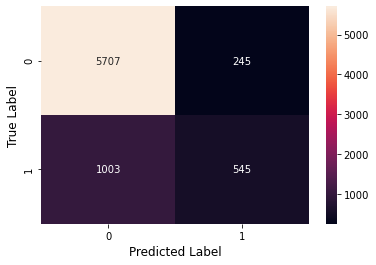

In [23]:
# confusion matrix
cat_confusion_matrix = metrics.confusion_matrix(y_test.drop('ID', axis=1),pred_cat)
sns.heatmap(cat_confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [24]:
model_score(X_test, cat_model_base)

auc_score: 0.7902501341481205


#### 5th Cat Model - same as 4, expanded categoric features

In [26]:
cat_model_base2 = CatBoostClassifier (random_state = 42, eval_metric = 'AUC')
cat_model_base2.fit(X_train, y_train, early_stopping_rounds = 100, cat_features=categorical_columns)
pred_cat2 = cat_model_base2.predict(X_test)

Learning rate set to 0.038933
0:	total: 10.8ms	remaining: 10.8s
1:	total: 23.2ms	remaining: 11.6s
2:	total: 31.5ms	remaining: 10.5s
3:	total: 37.2ms	remaining: 9.26s
4:	total: 44.5ms	remaining: 8.85s
5:	total: 53.1ms	remaining: 8.79s
6:	total: 61.3ms	remaining: 8.69s
7:	total: 71ms	remaining: 8.8s
8:	total: 80.3ms	remaining: 8.84s
9:	total: 88ms	remaining: 8.71s
10:	total: 98.1ms	remaining: 8.82s
11:	total: 106ms	remaining: 8.69s
12:	total: 116ms	remaining: 8.82s
13:	total: 125ms	remaining: 8.8s
14:	total: 134ms	remaining: 8.8s
15:	total: 141ms	remaining: 8.69s
16:	total: 148ms	remaining: 8.53s
17:	total: 156ms	remaining: 8.49s
18:	total: 165ms	remaining: 8.51s
19:	total: 176ms	remaining: 8.61s
20:	total: 179ms	remaining: 8.36s
21:	total: 188ms	remaining: 8.36s
22:	total: 196ms	remaining: 8.32s
23:	total: 207ms	remaining: 8.43s
24:	total: 221ms	remaining: 8.63s
25:	total: 233ms	remaining: 8.73s
26:	total: 242ms	remaining: 8.71s
27:	total: 250ms	remaining: 8.66s
28:	total: 259ms	remaini

239:	total: 2.64s	remaining: 8.36s
240:	total: 2.65s	remaining: 8.36s
241:	total: 2.67s	remaining: 8.36s
242:	total: 2.68s	remaining: 8.35s
243:	total: 2.69s	remaining: 8.34s
244:	total: 2.7s	remaining: 8.33s
245:	total: 2.71s	remaining: 8.32s
246:	total: 2.72s	remaining: 8.31s
247:	total: 2.74s	remaining: 8.3s
248:	total: 2.75s	remaining: 8.28s
249:	total: 2.76s	remaining: 8.27s
250:	total: 2.77s	remaining: 8.26s
251:	total: 2.78s	remaining: 8.25s
252:	total: 2.79s	remaining: 8.24s
253:	total: 2.8s	remaining: 8.21s
254:	total: 2.81s	remaining: 8.2s
255:	total: 2.82s	remaining: 8.19s
256:	total: 2.83s	remaining: 8.18s
257:	total: 2.84s	remaining: 8.16s
258:	total: 2.85s	remaining: 8.15s
259:	total: 2.87s	remaining: 8.16s
260:	total: 2.88s	remaining: 8.14s
261:	total: 2.88s	remaining: 8.13s
262:	total: 2.9s	remaining: 8.12s
263:	total: 2.91s	remaining: 8.11s
264:	total: 2.92s	remaining: 8.1s
265:	total: 2.93s	remaining: 8.09s
266:	total: 2.94s	remaining: 8.08s
267:	total: 2.95s	remainin

490:	total: 5.49s	remaining: 5.69s
491:	total: 5.5s	remaining: 5.68s
492:	total: 5.51s	remaining: 5.67s
493:	total: 5.53s	remaining: 5.66s
494:	total: 5.54s	remaining: 5.65s
495:	total: 5.55s	remaining: 5.64s
496:	total: 5.56s	remaining: 5.63s
497:	total: 5.57s	remaining: 5.61s
498:	total: 5.58s	remaining: 5.6s
499:	total: 5.59s	remaining: 5.59s
500:	total: 5.6s	remaining: 5.58s
501:	total: 5.61s	remaining: 5.57s
502:	total: 5.62s	remaining: 5.56s
503:	total: 5.63s	remaining: 5.54s
504:	total: 5.64s	remaining: 5.53s
505:	total: 5.66s	remaining: 5.52s
506:	total: 5.67s	remaining: 5.51s
507:	total: 5.68s	remaining: 5.5s
508:	total: 5.69s	remaining: 5.49s
509:	total: 5.7s	remaining: 5.48s
510:	total: 5.71s	remaining: 5.47s
511:	total: 5.73s	remaining: 5.46s
512:	total: 5.74s	remaining: 5.45s
513:	total: 5.75s	remaining: 5.43s
514:	total: 5.76s	remaining: 5.42s
515:	total: 5.77s	remaining: 5.41s
516:	total: 5.78s	remaining: 5.4s
517:	total: 5.79s	remaining: 5.38s
518:	total: 5.8s	remaining

739:	total: 8.37s	remaining: 2.94s
740:	total: 8.38s	remaining: 2.93s
741:	total: 8.4s	remaining: 2.92s
742:	total: 8.41s	remaining: 2.91s
743:	total: 8.42s	remaining: 2.9s
744:	total: 8.43s	remaining: 2.88s
745:	total: 8.44s	remaining: 2.87s
746:	total: 8.45s	remaining: 2.86s
747:	total: 8.46s	remaining: 2.85s
748:	total: 8.48s	remaining: 2.84s
749:	total: 8.49s	remaining: 2.83s
750:	total: 8.5s	remaining: 2.82s
751:	total: 8.52s	remaining: 2.81s
752:	total: 8.53s	remaining: 2.8s
753:	total: 8.54s	remaining: 2.79s
754:	total: 8.55s	remaining: 2.77s
755:	total: 8.56s	remaining: 2.76s
756:	total: 8.58s	remaining: 2.75s
757:	total: 8.59s	remaining: 2.74s
758:	total: 8.61s	remaining: 2.73s
759:	total: 8.62s	remaining: 2.72s
760:	total: 8.63s	remaining: 2.71s
761:	total: 8.64s	remaining: 2.7s
762:	total: 8.65s	remaining: 2.69s
763:	total: 8.66s	remaining: 2.67s
764:	total: 8.67s	remaining: 2.66s
765:	total: 8.68s	remaining: 2.65s
766:	total: 8.69s	remaining: 2.64s
767:	total: 8.7s	remainin

980:	total: 11.2s	remaining: 218ms
981:	total: 11.3s	remaining: 206ms
982:	total: 11.3s	remaining: 195ms
983:	total: 11.3s	remaining: 183ms
984:	total: 11.3s	remaining: 172ms
985:	total: 11.3s	remaining: 160ms
986:	total: 11.3s	remaining: 149ms
987:	total: 11.3s	remaining: 138ms
988:	total: 11.3s	remaining: 126ms
989:	total: 11.3s	remaining: 115ms
990:	total: 11.4s	remaining: 103ms
991:	total: 11.4s	remaining: 91.7ms
992:	total: 11.4s	remaining: 80.3ms
993:	total: 11.4s	remaining: 68.8ms
994:	total: 11.4s	remaining: 57.3ms
995:	total: 11.4s	remaining: 45.9ms
996:	total: 11.4s	remaining: 34.4ms
997:	total: 11.4s	remaining: 22.9ms
998:	total: 11.5s	remaining: 11.5ms
999:	total: 11.5s	remaining: 0us


In [27]:
print("Test Accuracy: ", accuracy_score(y_test.drop('ID', axis=1),pred_cat2))

Test Accuracy:  0.8328


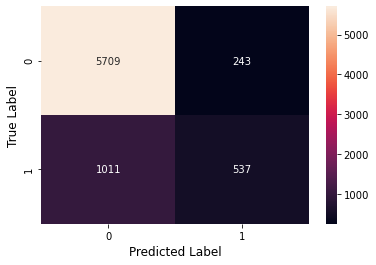

In [28]:
# confusion matrix
cat_confusion_matrix = metrics.confusion_matrix(y_test.drop('ID', axis=1),pred_cat2)
sns.heatmap(cat_confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [29]:
model_score(X_test, cat_model_base2)

auc_score: 0.796080476282265


#### Cat 6 - using grid search on best previous model (model 2)

In [30]:
params2={
    'depth': [6,8,10],
    'learning_rate' : [0.01, 0.05, 0.1],
    'iterations'    : [30, 50, 100]
}

In [31]:
clf = CatBoostClassifier()
cat_dims = [X_train.columns.get_loc(i) for i in categorical_columns[:-1]] 
clf.fit(X_train, np.ravel(y_train), cat_features=cat_dims)
res = clf.predict(X_test)
print('error:',1-np.mean(res==np.ravel(y_test)))

Learning rate set to 0.038933
0:	learn: 0.6718318	total: 10.2ms	remaining: 10.2s
1:	learn: 0.6524552	total: 19.5ms	remaining: 9.75s
2:	learn: 0.6346665	total: 28.7ms	remaining: 9.53s
3:	learn: 0.6183811	total: 36.6ms	remaining: 9.11s
4:	learn: 0.6031933	total: 45.6ms	remaining: 9.07s
5:	learn: 0.5899206	total: 53.5ms	remaining: 8.86s
6:	learn: 0.5772396	total: 60.3ms	remaining: 8.55s
7:	learn: 0.5659650	total: 69.5ms	remaining: 8.62s
8:	learn: 0.5553246	total: 78.7ms	remaining: 8.66s
9:	learn: 0.5458733	total: 87.4ms	remaining: 8.65s
10:	learn: 0.5369230	total: 94.7ms	remaining: 8.52s
11:	learn: 0.5290021	total: 103ms	remaining: 8.49s
12:	learn: 0.5215809	total: 112ms	remaining: 8.49s
13:	learn: 0.5149435	total: 122ms	remaining: 8.58s
14:	learn: 0.5088414	total: 130ms	remaining: 8.51s
15:	learn: 0.5034724	total: 138ms	remaining: 8.49s
16:	learn: 0.4982462	total: 145ms	remaining: 8.4s
17:	learn: 0.4936288	total: 152ms	remaining: 8.28s
18:	learn: 0.4895183	total: 158ms	remaining: 8.16s
1

173:	learn: 0.4233419	total: 1.83s	remaining: 8.67s
174:	learn: 0.4233182	total: 1.83s	remaining: 8.64s
175:	learn: 0.4232487	total: 1.84s	remaining: 8.63s
176:	learn: 0.4231088	total: 1.85s	remaining: 8.63s
177:	learn: 0.4230656	total: 1.86s	remaining: 8.61s
178:	learn: 0.4229912	total: 1.87s	remaining: 8.59s
179:	learn: 0.4229408	total: 1.88s	remaining: 8.58s
180:	learn: 0.4228606	total: 1.89s	remaining: 8.57s
181:	learn: 0.4227240	total: 1.9s	remaining: 8.55s
182:	learn: 0.4225797	total: 1.91s	remaining: 8.55s
183:	learn: 0.4225482	total: 1.92s	remaining: 8.52s
184:	learn: 0.4225238	total: 1.93s	remaining: 8.51s
185:	learn: 0.4224621	total: 1.94s	remaining: 8.5s
186:	learn: 0.4223263	total: 1.95s	remaining: 8.49s
187:	learn: 0.4222165	total: 1.96s	remaining: 8.47s
188:	learn: 0.4220595	total: 1.97s	remaining: 8.46s
189:	learn: 0.4220217	total: 1.98s	remaining: 8.45s
190:	learn: 0.4219989	total: 1.99s	remaining: 8.44s
191:	learn: 0.4218150	total: 2s	remaining: 8.42s
192:	learn: 0.421

338:	learn: 0.4102120	total: 3.47s	remaining: 6.77s
339:	learn: 0.4100948	total: 3.48s	remaining: 6.77s
340:	learn: 0.4100502	total: 3.5s	remaining: 6.76s
341:	learn: 0.4100265	total: 3.51s	remaining: 6.75s
342:	learn: 0.4098726	total: 3.52s	remaining: 6.74s
343:	learn: 0.4097106	total: 3.53s	remaining: 6.73s
344:	learn: 0.4096923	total: 3.54s	remaining: 6.72s
345:	learn: 0.4096256	total: 3.55s	remaining: 6.71s
346:	learn: 0.4095165	total: 3.56s	remaining: 6.7s
347:	learn: 0.4093181	total: 3.57s	remaining: 6.69s
348:	learn: 0.4092426	total: 3.58s	remaining: 6.67s
349:	learn: 0.4091248	total: 3.59s	remaining: 6.66s
350:	learn: 0.4089465	total: 3.6s	remaining: 6.65s
351:	learn: 0.4088195	total: 3.61s	remaining: 6.64s
352:	learn: 0.4087788	total: 3.62s	remaining: 6.63s
353:	learn: 0.4085789	total: 3.63s	remaining: 6.62s
354:	learn: 0.4085765	total: 3.64s	remaining: 6.61s
355:	learn: 0.4085357	total: 3.65s	remaining: 6.6s
356:	learn: 0.4084621	total: 3.66s	remaining: 6.59s
357:	learn: 0.40

500:	learn: 0.3986680	total: 7.81s	remaining: 7.78s
501:	learn: 0.3986085	total: 7.87s	remaining: 7.8s
502:	learn: 0.3985256	total: 7.91s	remaining: 7.81s
503:	learn: 0.3984013	total: 7.95s	remaining: 7.82s
504:	learn: 0.3983515	total: 7.99s	remaining: 7.83s
505:	learn: 0.3983125	total: 8.02s	remaining: 7.83s
506:	learn: 0.3982524	total: 8.05s	remaining: 7.83s
507:	learn: 0.3981998	total: 8.09s	remaining: 7.83s
508:	learn: 0.3981539	total: 8.14s	remaining: 7.86s
509:	learn: 0.3980958	total: 8.18s	remaining: 7.86s
510:	learn: 0.3980407	total: 8.21s	remaining: 7.86s
511:	learn: 0.3979973	total: 8.25s	remaining: 7.86s
512:	learn: 0.3978958	total: 8.28s	remaining: 7.87s
513:	learn: 0.3978079	total: 8.32s	remaining: 7.87s
514:	learn: 0.3977745	total: 8.36s	remaining: 7.87s
515:	learn: 0.3977510	total: 8.4s	remaining: 7.88s
516:	learn: 0.3977333	total: 8.43s	remaining: 7.88s
517:	learn: 0.3977206	total: 8.47s	remaining: 7.88s
518:	learn: 0.3976763	total: 8.5s	remaining: 7.88s
519:	learn: 0.3

659:	learn: 0.3894717	total: 13.5s	remaining: 6.94s
660:	learn: 0.3894250	total: 13.5s	remaining: 6.93s
661:	learn: 0.3893914	total: 13.5s	remaining: 6.91s
662:	learn: 0.3893506	total: 13.6s	remaining: 6.89s
663:	learn: 0.3892616	total: 13.6s	remaining: 6.88s
664:	learn: 0.3891801	total: 13.6s	remaining: 6.86s
665:	learn: 0.3891333	total: 13.7s	remaining: 6.85s
666:	learn: 0.3891143	total: 13.7s	remaining: 6.83s
667:	learn: 0.3890555	total: 13.7s	remaining: 6.82s
668:	learn: 0.3890102	total: 13.8s	remaining: 6.8s
669:	learn: 0.3889228	total: 13.8s	remaining: 6.79s
670:	learn: 0.3888385	total: 13.8s	remaining: 6.77s
671:	learn: 0.3888281	total: 13.8s	remaining: 6.75s
672:	learn: 0.3887915	total: 13.9s	remaining: 6.74s
673:	learn: 0.3887215	total: 13.9s	remaining: 6.73s
674:	learn: 0.3886425	total: 13.9s	remaining: 6.72s
675:	learn: 0.3886314	total: 14s	remaining: 6.7s
676:	learn: 0.3885658	total: 14s	remaining: 6.68s
677:	learn: 0.3885427	total: 14s	remaining: 6.66s
678:	learn: 0.388473

824:	learn: 0.3805904	total: 19s	remaining: 4.03s
825:	learn: 0.3804488	total: 19.1s	remaining: 4.01s
826:	learn: 0.3803826	total: 19.1s	remaining: 3.99s
827:	learn: 0.3803543	total: 19.1s	remaining: 3.97s
828:	learn: 0.3802485	total: 19.1s	remaining: 3.95s
829:	learn: 0.3802025	total: 19.2s	remaining: 3.93s
830:	learn: 0.3801500	total: 19.2s	remaining: 3.91s
831:	learn: 0.3801436	total: 19.2s	remaining: 3.88s
832:	learn: 0.3801025	total: 19.3s	remaining: 3.86s
833:	learn: 0.3800531	total: 19.3s	remaining: 3.84s
834:	learn: 0.3800417	total: 19.3s	remaining: 3.82s
835:	learn: 0.3799942	total: 19.4s	remaining: 3.8s
836:	learn: 0.3799617	total: 19.4s	remaining: 3.78s
837:	learn: 0.3799165	total: 19.4s	remaining: 3.76s
838:	learn: 0.3798631	total: 19.5s	remaining: 3.74s
839:	learn: 0.3797566	total: 19.5s	remaining: 3.71s
840:	learn: 0.3796906	total: 19.5s	remaining: 3.69s
841:	learn: 0.3796521	total: 19.6s	remaining: 3.67s
842:	learn: 0.3796179	total: 19.6s	remaining: 3.65s
843:	learn: 0.3

990:	learn: 0.3716351	total: 24.3s	remaining: 220ms
991:	learn: 0.3715814	total: 24.3s	remaining: 196ms
992:	learn: 0.3715643	total: 24.3s	remaining: 171ms
993:	learn: 0.3715338	total: 24.3s	remaining: 147ms
994:	learn: 0.3714232	total: 24.4s	remaining: 122ms
995:	learn: 0.3713971	total: 24.4s	remaining: 98ms
996:	learn: 0.3713051	total: 24.4s	remaining: 73.5ms
997:	learn: 0.3712283	total: 24.5s	remaining: 49ms
998:	learn: 0.3711059	total: 24.5s	remaining: 24.5ms
999:	learn: 0.3710817	total: 24.5s	remaining: 0us
error: 1.0


<ipython-input-31-c2212756a7e9>:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print('error:',1-np.mean(res==np.ravel(y_test)))


In [32]:
grid = GridSearchCV(estimator=clf, param_grid=params2, cv = 2, n_jobs=-1)
grid.fit(X_train, y_train)

0:	learn: 0.6662715	total: 8.3ms	remaining: 822ms
1:	learn: 0.6418663	total: 16.5ms	remaining: 808ms
2:	learn: 0.6205567	total: 23.6ms	remaining: 764ms
3:	learn: 0.6008139	total: 30.8ms	remaining: 739ms
4:	learn: 0.5835694	total: 38.2ms	remaining: 726ms
5:	learn: 0.5681053	total: 45.6ms	remaining: 714ms
6:	learn: 0.5547543	total: 52.3ms	remaining: 695ms
7:	learn: 0.5428733	total: 58.2ms	remaining: 669ms
8:	learn: 0.5320889	total: 63.2ms	remaining: 640ms
9:	learn: 0.5229247	total: 68.4ms	remaining: 615ms
10:	learn: 0.5146388	total: 73.8ms	remaining: 597ms
11:	learn: 0.5070854	total: 79ms	remaining: 579ms
12:	learn: 0.5002594	total: 84ms	remaining: 562ms
13:	learn: 0.4938648	total: 89.1ms	remaining: 547ms
14:	learn: 0.4884807	total: 94.3ms	remaining: 535ms
15:	learn: 0.4835066	total: 99.8ms	remaining: 524ms
16:	learn: 0.4791341	total: 105ms	remaining: 513ms
17:	learn: 0.4749695	total: 110ms	remaining: 503ms
18:	learn: 0.4715340	total: 116ms	remaining: 493ms
19:	learn: 0.4682037	total: 12

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fbfa4549910>,
             n_jobs=-1,
             param_grid={'depth': [6, 8, 10], 'iterations': [30, 50, 100],
                         'learning_rate': [0.01, 0.05, 0.1]})

In [33]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.8166666666666667

 The best parameters across ALL searched params:
 {'depth': 6, 'iterations': 100, 'learning_rate': 0.05}


In [48]:
gridparams={'depth': 6,
            'learning_rate':0.05,
            'iterations': 100
            }
catboost_final_model = CatBoostClassifier(**gridparams)
catboost_final_model.fit(X_train,y_train)

0:	learn: 0.6662715	total: 3.54ms	remaining: 350ms
1:	learn: 0.6418663	total: 7.63ms	remaining: 374ms
2:	learn: 0.6205567	total: 11.9ms	remaining: 385ms
3:	learn: 0.6008139	total: 14.8ms	remaining: 355ms
4:	learn: 0.5835694	total: 17.5ms	remaining: 333ms
5:	learn: 0.5681053	total: 20.5ms	remaining: 321ms
6:	learn: 0.5547543	total: 23ms	remaining: 305ms
7:	learn: 0.5428733	total: 25.5ms	remaining: 294ms
8:	learn: 0.5320889	total: 28.1ms	remaining: 284ms
9:	learn: 0.5229247	total: 31ms	remaining: 279ms
10:	learn: 0.5146388	total: 34.6ms	remaining: 280ms
11:	learn: 0.5070854	total: 37.6ms	remaining: 276ms
12:	learn: 0.5002594	total: 40.1ms	remaining: 268ms
13:	learn: 0.4938648	total: 42.6ms	remaining: 262ms
14:	learn: 0.4884807	total: 45.1ms	remaining: 256ms
15:	learn: 0.4835066	total: 47.6ms	remaining: 250ms
16:	learn: 0.4791341	total: 50.1ms	remaining: 244ms
17:	learn: 0.4749695	total: 52.5ms	remaining: 239ms
18:	learn: 0.4715340	total: 55ms	remaining: 234ms
19:	learn: 0.4682037	total: 

auc_score: 0.7944105166916731


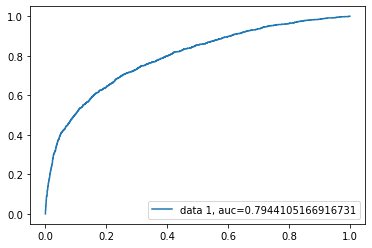

In [344]:
model_score(X_test, catboost_final_model)

### KNearestNeighbour Classifier

In [38]:
#Default model without hyperparameter tuning
d_model = KNeighborsClassifier()
d_model.fit(X_train_p, y_train)
model_score(X_test=X_test_p, model=d_model)

auc_score: 0.6684601923050206


#### Hyperparameter Tuning for KNN Classifier

In [39]:
for n_neighbors in [5, 6, 7, 8, 9]:
    print(f'\nn_neighbors: {n_neighbors}')
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    crossValidation(X_train=X_train_p, y_train=y_train, model=model)


n_neighbors: 5
scores: [0.6563566  0.66485611 0.66524289 0.65558729 0.66468754]
cv_score: 0.66135

n_neighbors: 6
scores: [0.67077329 0.6633973  0.65894979 0.67114057 0.66068086]
cv_score: 0.66499

n_neighbors: 7
scores: [0.67049076 0.67715611 0.66511678 0.66104108 0.67524196]
cv_score: 0.66981

n_neighbors: 8
scores: [0.6798596  0.66049845 0.68104913 0.66149998 0.66353981]
cv_score: 0.66929

n_neighbors: 9
scores: [0.68592263 0.67893977 0.66656826 0.6708632  0.66166668]
cv_score: 0.67279


In [40]:
for n_neighbors in [12, 15, 18, 21]:
    print(f'\nn_neighbors: {n_neighbors}')
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    crossValidation(X_train=X_train_p, y_train=y_train, model=model)


n_neighbors: 12
scores: [0.678575   0.67210092 0.69700672 0.67650981 0.67494638]
cv_score: 0.67983

n_neighbors: 15
scores: [0.67012838 0.68371524 0.6813129  0.69236474 0.68920951]
cv_score: 0.68335

n_neighbors: 18
scores: [0.6986056  0.69363406 0.68522017 0.69114276 0.67609835]
cv_score: 0.68894

n_neighbors: 21
scores: [0.695116   0.69453654 0.68892742 0.68427798 0.69056897]
cv_score: 0.69069


In [41]:
for n_neighbors in [24, 27, 30, 33, 36]:
    print(f'\nn_neighbors: {n_neighbors}')
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    crossValidation(X_train=X_train_p, y_train=y_train, model=model)


n_neighbors: 24
scores: [0.697612   0.68482804 0.69526947 0.68585129 0.68752835]
cv_score: 0.69022

n_neighbors: 27
scores: [0.67685241 0.68747807 0.70098113 0.68630807 0.67766771]
cv_score: 0.68586

n_neighbors: 30
scores: [0.69978906 0.68150164 0.68308401 0.68703445 0.68796509]
cv_score: 0.68787

n_neighbors: 33
scores: [0.68461913 0.70263446 0.68290304 0.6689195  0.68757141]
cv_score: 0.68533

n_neighbors: 36
scores: [0.69435091 0.67775122 0.68705461 0.68970793 0.69041031]
cv_score: 0.68785


In [42]:
power_param = [1,2] # 1 stand for manhattan_distance (l1), and euclidean_distance (l2) for p = 2

for n_neighbors in [21]:
    for i in power_param:
        print(f'\nn_neighbors: {n_neighbors}, p: {i}')
        model = KNeighborsClassifier(n_neighbors=n_neighbors, p=i)
        crossValidation(X_train=X_train_p, y_train=y_train, model=model)


n_neighbors: 21, p: 1
scores: [0.69187353 0.70250102 0.70002279 0.68990568 0.68692266]
cv_score: 0.69425

n_neighbors: 21, p: 2
scores: [0.68136115 0.67822673 0.68771998 0.69328422 0.69164527]
cv_score: 0.68645


In [43]:
power_param = [1] # 1 stand for manhattan_distance (l1), and euclidean_distance (l2) for p = 2
leaf_size_knn = [25, 30, 35, 40] #default is 30

for n_neighbors in [21]:
    for i in power_param:
        for l in leaf_size_knn:
            print(f'\nn_neighbors: {n_neighbors}, p: {i}, leaf size: {l}')
            model = KNeighborsClassifier(n_neighbors=n_neighbors, p=i, leaf_size=l)
            crossValidation(X_train=X_train_p, y_train=y_train, model=model)


n_neighbors: 21, p: 1, leaf size: 25
scores: [0.68108496 0.70221778 0.68409581 0.70088625 0.70489378]
cv_score: 0.69464

n_neighbors: 21, p: 1, leaf size: 30
scores: [0.70304352 0.70628303 0.69070925 0.69082742 0.69645047]
cv_score: 0.69746

n_neighbors: 21, p: 1, leaf size: 35
scores: [0.68903434 0.69061404 0.68812298 0.70255245 0.71181728]
cv_score: 0.69643

n_neighbors: 21, p: 1, leaf size: 40
scores: [0.67592722 0.69650216 0.69853239 0.6899222  0.71314639]
cv_score: 0.69481


#### Retrain KNN model with entire training data

In [453]:
knn_model = KNeighborsClassifier(n_neighbors=21,p=1,leaf_size=30)
knn_model.fit(X_train_p, y_train)

KNeighborsClassifier(n_neighbors=21, p=1)

#### Test Model

auc_score: 0.7073239121412297


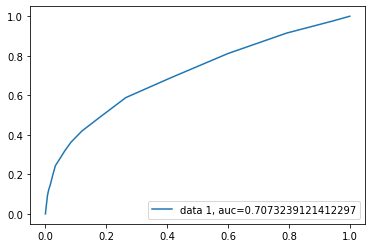

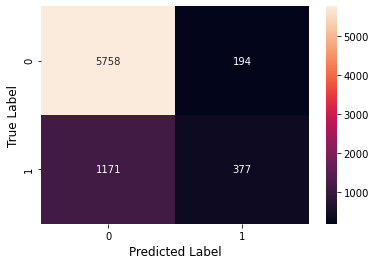

In [454]:
model_score(X_test=X_test_p, model=knn_model)

### Ensemble Model

In this section we will explore how we can stack the models to generate final classifier

auc_score: 0.7957317562897669


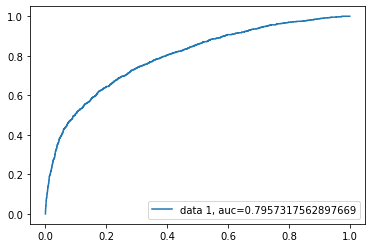

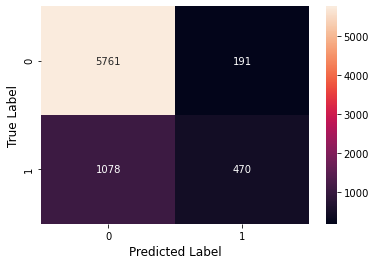

In [455]:
vc_model = VotingClassifier(estimators=[('xgb', xgb_model), 
                                        ('rf', rf_model), 
                                        ('lr', lr_model),
                                        ('knn', knn_model)],
                            weights=[3,2,1,1],
                            voting='soft')
vc_model.fit(X_train_p, y_train)
model_score(X_test=X_test_p, model=vc_model)

### Pseudo Labeling

In this technique we try to take benifit of the labels we generate for the test data.
The whole process can be described in 2 phases 

Process:

Phase 1:
- Tune a model to get the best CV score on the train data
- Train the model on complete train data
- Generate labels for the test data
- Augment the train data with the generated test features and labels

Phase 2:
- Tune the model to get best CV score on the Augmented train data
- Train the model using complete Augmented train data
- Generate labels for the test data
- Compute AUC score

We will perform the experiment with XGBClassifier model which we tuned in the earlier step

#### Phase 1

##### Training Base model

In [456]:
colsample_bytree = 0.3
n_estimators = 600
max_depth = 7
learning_rate = 0.01

xgb_model = XGBClassifier(colsample_bytree=colsample_bytree, early_stopping_rounds=5, 
                          n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, 
                          learning_rate=learning_rate, objective='binary:logistic')
xgb_model.fit(X_train_p, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, early_stopping_rounds=5,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=600, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

##### AUC score for base model

auc_score: 0.7966432254765081


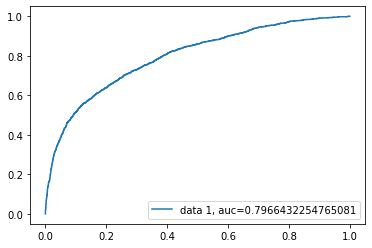

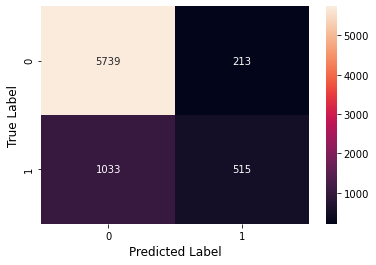

In [457]:
model_score(X_test=X_test_p, model=xgb_model)

In [458]:
y_pred = xgb_model.predict_proba(X_test_p)
sol = pd.DataFrame({"ID":testIds, "default.payment.next.month":y_pred[:,1]})
sol.to_csv("data/submission.csv", index=False)

##### Augmenting the train data

In [459]:
train1 = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
print(f'train shape: {train.shape}')
print(f'test shape: {test.shape}')

train shape: (22500, 24)
test shape: (7500, 24)


In [460]:
testIds = test['ID']

In [461]:
best_result = "data/submission.csv"
test_results = pd.read_csv(best_result)

# take only data where the model was able to predict with confidence
confident_results = test_results[(test_results['default.payment.next.month'] < 0.2) | 
                                 (test_results['default.payment.next.month'] > 0.8)]
test_subset = pd.merge(confident_results,test,on='ID')
train = pd.concat([train1, test_subset]).round({'default.payment.next.month':0})
train.drop(['ID'], axis=1, inplace=True)
test.drop(['ID'], axis=1, inplace=True)

In [462]:
# Grab target as y, remove target from X
train_copy = train.copy()
y_train_a = train_copy['default.payment.next.month']
X_train_a = train_copy.drop(columns=['default.payment.next.month'])
X_train_a.shape

(27749, 23)

#### Phase 2

##### Train model with Augmented train data

In [463]:
# Fit the preprocessor using the augmented training data
X_train_a_p = fetaure_preprocessor.fit_transform(X_train_a, y_train_a)
X_train_a_p.shape

(27749, 156)

In [464]:
# transform test data
X_test_a = test.copy()
X_test_a_p = fetaure_preprocessor.transform(X_test_a)
X_test_a_p.shape

(7500, 156)

In [268]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

for colsample_bytree in [0.3]:
    for learning_rate in [0.01]:
        for n_estimators in [650, 660, 670]:
                for max_depth in [7]:
                    print(f'\ncolsample_bytree: {colsample_bytree}, learning_rate: {learning_rate}, 
                          n_estimators: {n_estimators}, max_depth: {max_depth}')
                    model = XGBClassifier(colsample_bytree=colsample_bytree, early_stopping_rounds=5,
                                          n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, 
                                          learning_rate=learning_rate, objective='binary:logistic', 
                                          verbosity = 0, silent=True)
                    crossValidation(X_train=X_train_a_p, y_train=y_train_a, model=model)


colsample_bytree: 0.3, learning_rate: 0.01, n_estimators: 650, max_depth: 7
scores: [0.80106323 0.81679153 0.8016998  0.81734255 0.80765121]
cv_score: 0.80891

colsample_bytree: 0.3, learning_rate: 0.01, n_estimators: 660, max_depth: 7
scores: [0.81251285 0.80339654 0.78555936 0.81729779 0.82182829]
cv_score: 0.80812

colsample_bytree: 0.3, learning_rate: 0.01, n_estimators: 670, max_depth: 7
scores: [0.81451122 0.80819465 0.80786165 0.79961095 0.81032675]
cv_score: 0.8081


auc_score: 0.7962089806305743


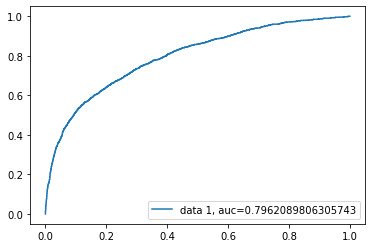

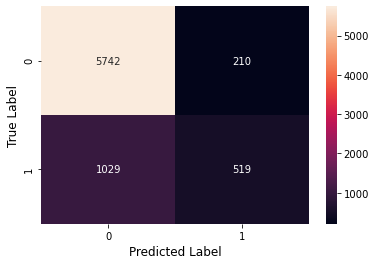

In [465]:
colsample_bytree = 0.3
n_estimators = 650
max_depth = 7
learning_rate = 0.01

xgb_model = XGBClassifier(colsample_bytree=colsample_bytree, early_stopping_rounds=5, 
                          n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, 
                          learning_rate=learning_rate, objective='binary:logistic')
xgb_model.fit(X_train_a_p, y_train_a)
model_score(X_test=X_test_a_p, model=xgb_model)